# Deep Learning Audio Classification Project


### Imports



In [4]:
import os
import random
import requests
import zipfile
import matplotlib.pyplot as plt
import math
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui lit les fichiers audio et extrait les spectrogrammes qui seront traités ensuite comme des images.

In [5]:
import librosa
import librosa.display

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda', index=0)

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classer les différents fichiers audio suivant ces 10 classes.

#### Téléchargement du corpus


In [8]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2024-05-06 14:31:58--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: 'dataset.zip'

dataset.zip         100%[===================>] 122.72M   640KB/s    in 3m 19s  

2024-05-06 14:35:19 (630 KB/s) - 'dataset.zip' saved [128685900/128685900]



La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [9]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [10]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))

                    # add associated label
                    labels.append(idx)

    # mélange les données
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [11]:
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 32.3 s, sys: 18.3 s, total: 50.6 s
Wall time: 21.7 s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [12]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [13]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[37] = 1 -> clock_tick
• y_train[205] = 6 -> rain
• y_train[184] = 5 -> helicopter
• y_train[117] = 3 -> crying_baby
• y_train[115] = 3 -> crying_baby
• y_train[294] = 9 -> sneezing
• y_train[27] = 0 -> chainsaw
• y_train[149] = 4 -> dog
• y_train[81] = 2 -> crackling_fire
• y_train[272] = 8 -> sea_waves


**Affichage de quelques spectrogrammes**


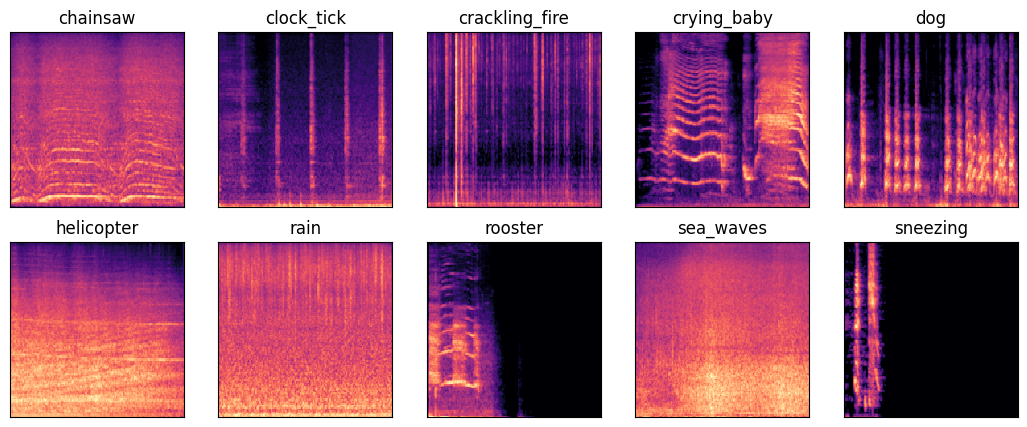

In [9]:
plt.figure(figsize=(13,5))

n = 0
for i in range(10):
      # récupération d'une image et de son label associé
      img, target = x_train[n], y_train[n]
      # affiche du spectrogramme
      plt.subplot(2,5,i+1)
      # img = librosa.power_to_db(img)
      librosa.display.specshow(img, cmap='magma')
      # ajout d'un titre à l'image
      plt.title(idx_to_classes[target])
      #plt.colorbar(format='%+2.0f dB')
      n += 32

plt.show()

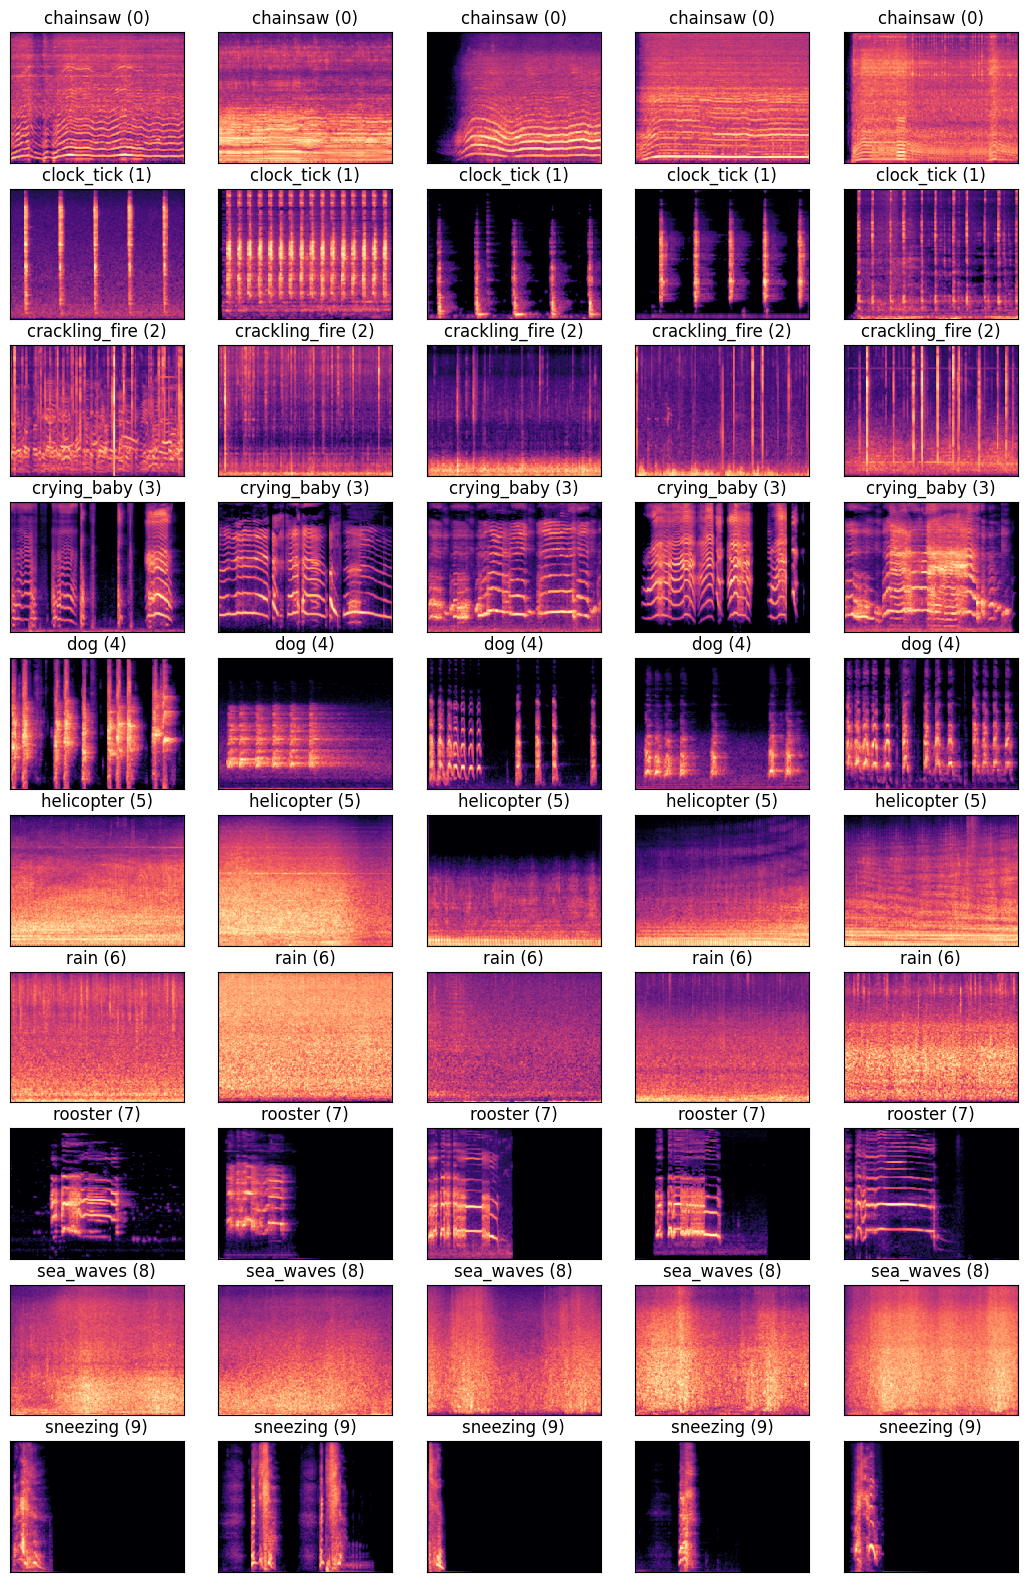

In [ ]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        # img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32

plt.show()

In [14]:
import random
import numpy as np
import librosa

idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def augment_audio(y, sr, augmentation_type=None):
    """
    :param y: Audio time series.
    :param sr: Sampling rate of y.
    :return: Augmented audio time series.
    """
    if augmentation_type == 'TS':
        # Time Stretching TS
        time_stretch_factors = [0.81, 0.93, 1.07, 1.23]
        rate = random.choice(time_stretch_factors)
        y = librosa.effects.time_stretch(y, rate=rate)
    elif augmentation_type == 'PS1':
        # Pitch Shifting 1
        pitch_shift_values = [-2, -1, 1, 2]
        n_steps = random.choice(pitch_shift_values)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    elif augmentation_type == 'PS2':
        # Pitch Shifting 2
        pitch_shift_values = [-3.5, -2.5, 2.5, 3.5]
        n_steps = random.choice(pitch_shift_values)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

    return y



def load_and_augment_dataset(path, augmentation_types=[]):
    """
    Load and optionally augment dataset from a given directory.
    :param path: Directory path where audio files are stored.
    :param augmentation_types: List of augmentation types to apply ('TS', 'PS1', 'PS2').
    :return: Tuple of numpy arrays (spectrograms, labels).
    """
    specs = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if not entry.name.startswith('.') and entry.name.endswith('.wav'):
                    # Load audio
                    y, sr = librosa.load(entry.path)

                    # Convert original audio to melspectrogram and add to dataset
                    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, power=2.0)
                    S_dB = librosa.power_to_db(S, ref=np.max)
                    if S_dB.shape[1] < 216:
                        pad_width = 216 - S_dB.shape[1]
                        S_dB = np.pad(S_dB, ((0, 0), (0, pad_width)), mode='constant')
                    elif S_dB.shape[1] > 216:
                        S_dB = S_dB[:, :216]
                    specs.append(S_dB)
                    labels.append(idx)

                    # Apply and store augmentations
                    if augmentation_types:
                        for aug_type in augmentation_types:
                            # Apply augmentation to a copy of the original audio
                            y_aug = augment_audio(np.copy(y), sr, aug_type)

                            # Convert augmented audio to melspectrogram
                            S_aug = librosa.feature.melspectrogram(y=y_aug, sr=sr, n_fft=2048, hop_length=512, power=2.0)
                            S_dB_aug = librosa.power_to_db(S_aug, ref=np.max)
                            if S_dB_aug.shape[1] < 216:
                                pad_width = 216 - S_dB_aug.shape[1]
                                S_dB_aug = np.pad(S_dB_aug, ((0, 0), (0, pad_width)), mode='constant')
                            elif S_dB_aug.shape[1] > 216:
                                S_dB_aug = S_dB_aug[:, :216]
                            specs.append(S_dB_aug)
                            labels.append(idx)

    return np.array(specs), np.array(labels)



# Example usage:
train_dir = './data/train'
test_dir = './data/test'

# Load the original dataset
x_train, y_train = load_and_augment_dataset(train_dir, augmentation_types=[])
x_test, y_test = load_and_augment_dataset(test_dir, augmentation_types=[])

# Load dataset with time stretching only
x_train_ts, y_train_ts = load_and_augment_dataset(train_dir, augmentation_types=['TS'])
x_test_ts, y_test_ts = load_and_augment_dataset(test_dir, augmentation_types=['TS'])

# Load dataset with both types of pitch shifting
x_train_ps, y_train_ps = load_and_augment_dataset(train_dir, augmentation_types=['PS1', 'PS2'])
x_test_ps, y_test_ps = load_and_augment_dataset(test_dir, augmentation_types=['PS1', 'PS2'])

# Load dataset with all augmentations combined
x_train_all, y_train_all = load_and_augment_dataset(train_dir, augmentation_types=['TS', 'PS1', 'PS2'])
x_test_all, y_test_all = load_and_augment_dataset(test_dir, augmentation_types=['TS', 'PS1', 'PS2'])

# Verify sizes of the datasets:
print(f'Original Train: {x_train.shape}, {y_train.shape}')
print(f'Original Test: {x_test.shape}, {y_test.shape}')
print(f'TS Train: {x_train_ts.shape}, {y_train_ts.shape}')
print(f'TS Test: {x_test_ts.shape}, {y_test_ts.shape}')
print(f'PS Train: {x_train_ps.shape}, {y_train_ps.shape}')
print(f'PS Test: {x_test_ps.shape}, {y_test_ps.shape}')
print(f'All Aug Train: {x_train_all.shape}, {y_train_all.shape}')
print(f'All Aug Test: {x_test_all.shape}, {y_test_all.shape}')

Original Train: (320, 128, 216), (320,)
Original Test: (80, 128, 216), (80,)
TS Train: (640, 128, 216), (640,)
TS Test: (160, 128, 216), (160,)
PS Train: (960, 128, 216), (960,)
PS Test: (240, 128, 216), (240,)
All Aug Train: (1280, 128, 216), (1280,)
All Aug Test: (320, 128, 216), (320,)


# Générateurs de données pour Pytorch

Création d'un générateur de données (un « DataLoader ») pour les jeux de train et de test

In [21]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

In [22]:
# Convert all numpy arrays to PyTorch tensors
X_train = torch.from_numpy(x_train).float()
Y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(x_test).float()
Y_test = torch.from_numpy(y_test).long()

X_train_ts = torch.from_numpy(x_train_ts).float()
Y_train_ts = torch.from_numpy(y_train_ts).long()
X_test_ts = torch.from_numpy(x_test_ts).float()
Y_test_ts = torch.from_numpy(y_test_ts).long()

X_train_ps = torch.from_numpy(x_train_ps).float()
Y_train_ps = torch.from_numpy(y_train_ps).long()
X_test_ps = torch.from_numpy(x_test_ps).float()
Y_test_ps = torch.from_numpy(y_test_ps).long()

X_train_all = torch.from_numpy(x_train_all).float()
Y_train_all = torch.from_numpy(y_train_all).long()
X_test_all = torch.from_numpy(x_test_all).float()
Y_test_all = torch.from_numpy(y_test_all).long()


In [23]:
# Setup DataLoaders
def create_dataloader(x, y, batch_size=32, shuffle=True):
    dataset = Dataset(x, y)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

In [24]:
# Create DataLoaders for each dataset
train_loader = create_dataloader(X_train, Y_train)
test_loader = create_dataloader(X_test, Y_test, shuffle=False)

train_loader_ts = create_dataloader(X_train_ts, Y_train_ts)
test_loader_ts = create_dataloader(X_test_ts, Y_test_ts, shuffle=False)

train_loader_ps = create_dataloader(X_train_ps, Y_train_ps)
test_loader_ps = create_dataloader(X_test_ps, Y_test_ps, shuffle=False)

train_loader_all = create_dataloader(X_train_all, Y_train_all)
test_loader_all = create_dataloader(X_test_all, Y_test_all, shuffle=False)

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devez :
* complèter l'architecture MLP puis celle du CNN plus bas;
* lancer l'apprentissage ;
* évaluer les modèles sur le jeu de test ;


### Réseau MLP

Dans cette section, il faut compléter le réseau dense ci-dessous, qui contient une couche cachée avec la fonction d'activation ReLU et une couche de sortie.

In [25]:
input_size = 128*216
output_size = 10

In [26]:
input_size

27648

In [27]:
# Perceptron multi-couche
class MLP(nn.Module):
    def __init__(self, num_hidden=50):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(128*216, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        # vous pouvez définir d'autres couches dans un deuxième temps

    def forward(self, spectro):
        flattened = spectro.view(-1, 128*216) # flatten le spectro
        out1 = F.relu(self.layer1(flattened))
        out2 = self.layer2(out1)
        return out2


Compléter la fonction d'apprentissage

In [28]:
def train(model, train_loader,test_loader ,batch_size=32, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9,
          num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # la loss
    criterion = nn.CrossEntropyLoss()
    # l'optimiseur
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            # if imgs.size()[0] < batch_size:
            #     continue
            # print(imgs.size())
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.to(torch.long)

            model.train() # met le modèle en mode train
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # sauvegarde iteration et loss
            iters.append(n)
            losses.append(float(loss)/batch_size)             # loss moyen

            if n % 20 == 0 :
              train_acc.append(get_accuracy(model, train_loader,test_loader, train=True)) # training accuracy
              val_acc.append(get_accuracy(model, train_loader,test_loader, train=False))  # test accuracy
              iters_acc.append(n)
            n += 1

        print(f"Epoch: {epoch}\nLoss: {losses[-1]}\nAcc Train: {train_acc[-1]}\nAcc Test: {val_acc[-1]}")



    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))
    train_max = max(train_acc)
    val_max = max(val_acc)
    print("Meilleur Précision finale Train : {}".format(train_max))
    print("Meilleur Précision finale Test : {}".format(val_max))
    return train_max, val_max

In [29]:
def get_accuracy(model,train_loader,test_loader, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        inp, labels = inp.to(device), labels.to(device)
        output = model(inp) # pas besoin de torch.softmax
        pred = output.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return correct / total

Instancier un MLP avec 50 neurones pour la couche cachée. Quel est le nombre de paramètres de ce modèle ?

In [30]:
model = MLP()
print(model)

MLP(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)


In [27]:
# Calculating total number of parameter
total_params_mlp1 = sum([p.numel() for p in model.parameters()])
print(total_params_mlp1)

1382960


In [32]:
import time

Training with batch size 8, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.2883550226688385
Acc Train: 0.1
Acc Test: 0.1
Epoch: 1
Loss: 0.2854236960411072
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.28788453340530396
Acc Train: 0.1
Acc Test: 0.1
Epoch: 3
Loss: 0.28506118059158325
Acc Train: 0.1
Acc Test: 0.1
Epoch: 4
Loss: 0.2860428988933563
Acc Train: 0.1
Acc Test: 0.1
Epoch: 5
Loss: 0.2875995934009552
Acc Train: 0.1
Acc Test: 0.1
Epoch: 6
Loss: 0.2888694703578949
Acc Train: 0.1
Acc Test: 0.1
Epoch: 7
Loss: 0.2876128852367401
Acc Train: 0.1
Acc Test: 0.1
Epoch: 8
Loss: 0.28826984763145447
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.28669387102127075
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.2875131368637085
Acc Train: 0.1
Acc Test: 0.1
Epoch: 11
Loss: 0.2878277599811554
Acc Train: 0.1
Acc Test: 0.1
Epoch: 12
Loss: 0.2889901399612427
Acc Train: 0.1
Acc Test: 0.1
Epoch: 13
Loss: 0.28675082325935364
Acc Train: 0.1
Acc Test: 0.1
Epoch: 14
Loss: 0.2885788083076477
Acc Train:

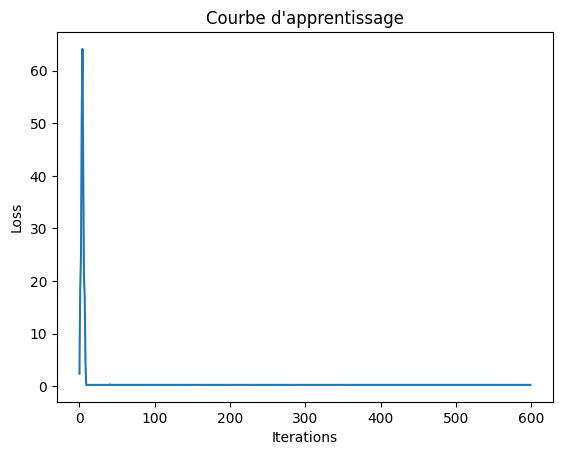

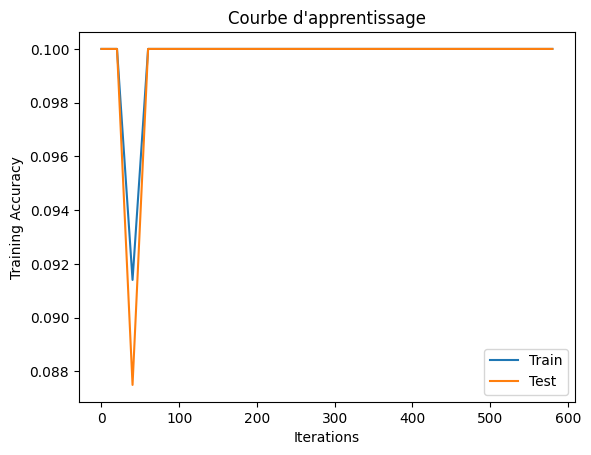

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.1
Meilleur Précision finale Test : 0.1
Training completed in 22.26 seconds
Training with batch size 8, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.2861420512199402
Acc Train: 0.1
Acc Test: 0.1
Epoch: 1
Loss: 0.2857249081134796
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.29044029116630554
Acc Train: 0.1
Acc Test: 0.1
Epoch: 3
Loss: 0.2897545099258423
Acc Train: 0.1
Acc Test: 0.1
Epoch: 4
Loss: 0.29096096754074097
Acc Train: 0.1
Acc Test: 0.1
Epoch: 5
Loss: 0.288109689950943
Acc Train: 0.1
Acc Test: 0.1
Epoch: 6
Loss: 0.29010117053985596
Acc Train: 0.1
Acc Test: 0.1
Epoch: 7
Loss: 0.2888771891593933
Acc Train: 0.1
Acc Test: 0.1
Epoch: 8
Loss: 0.28827202320098877
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.2881714999675751
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.2883888781070709
Acc Train: 0.1
Acc Test: 0.1
Epoch: 11
Loss: 0.28889042139053345
Acc Train: 0.1
Acc Test: 0.1
Epoch

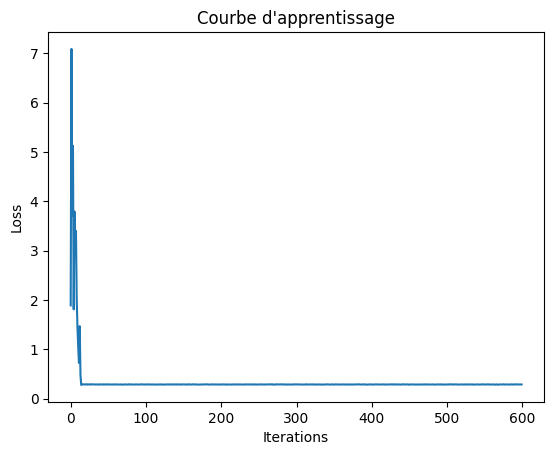

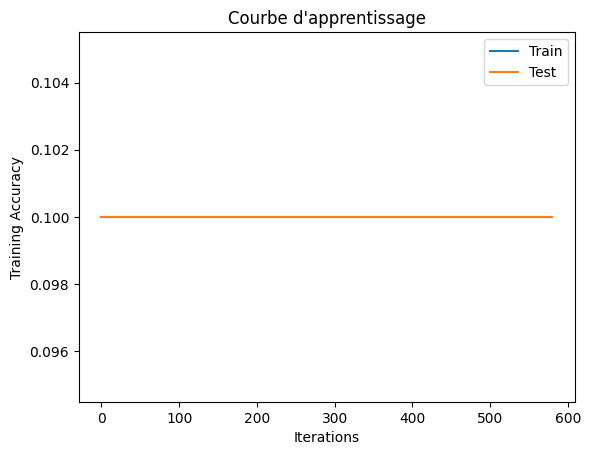

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.1
Meilleur Précision finale Test : 0.1
Training completed in 19.16 seconds
Training with batch size 16, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.14439177513122559
Acc Train: 0.1
Acc Test: 0.1
Epoch: 1
Loss: 0.14409103989601135
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.14568032324314117
Acc Train: 0.1
Acc Test: 0.1
Epoch: 3
Loss: 0.1453089714050293
Acc Train: 0.1
Acc Test: 0.1
Epoch: 4
Loss: 0.14320555329322815
Acc Train: 0.1
Acc Test: 0.1
Epoch: 5
Loss: 0.14363154768943787
Acc Train: 0.1
Acc Test: 0.1
Epoch: 6
Loss: 0.14412468671798706
Acc Train: 0.1
Acc Test: 0.1
Epoch: 7
Loss: 0.14438045024871826
Acc Train: 0.1
Acc Test: 0.1
Epoch: 8
Loss: 0.14402446150779724
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.14369745552539825
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.1439771205186844
Acc Train: 0.1
Acc Test: 0.1
Epoch: 11
Loss: 0.14453209936618805
Acc Train: 0.1
Acc Test: 0.1

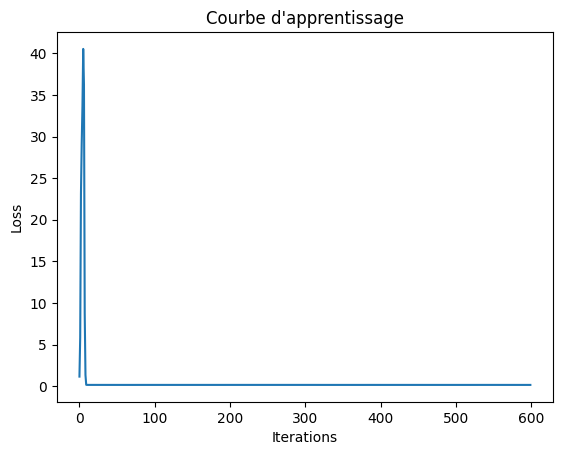

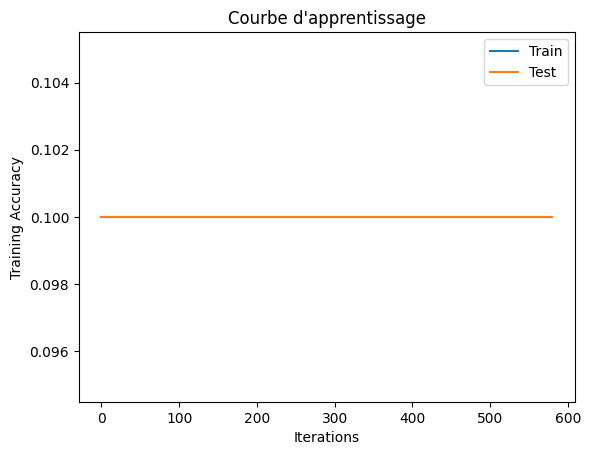

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.1
Meilleur Précision finale Test : 0.1
Training completed in 18.74 seconds
Training with batch size 16, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.14332640171051025
Acc Train: 0.1
Acc Test: 0.1
Epoch: 1
Loss: 0.14407317340373993
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.14523132145404816
Acc Train: 0.1
Acc Test: 0.1
Epoch: 3
Loss: 0.14369483292102814
Acc Train: 0.1
Acc Test: 0.1
Epoch: 4
Loss: 0.1437968611717224
Acc Train: 0.1
Acc Test: 0.1
Epoch: 5
Loss: 0.14567410945892334
Acc Train: 0.1
Acc Test: 0.1
Epoch: 6
Loss: 0.1437390297651291
Acc Train: 0.1
Acc Test: 0.1
Epoch: 7
Loss: 0.14490969479084015
Acc Train: 0.1
Acc Test: 0.1
Epoch: 8
Loss: 0.14515821635723114
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.1443725824356079
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.14376600086688995
Acc Train: 0.1
Acc Test: 0.1
Epoch: 11
Loss: 0.14458826184272766
Acc Train: 0.1
Acc Test: 0.1

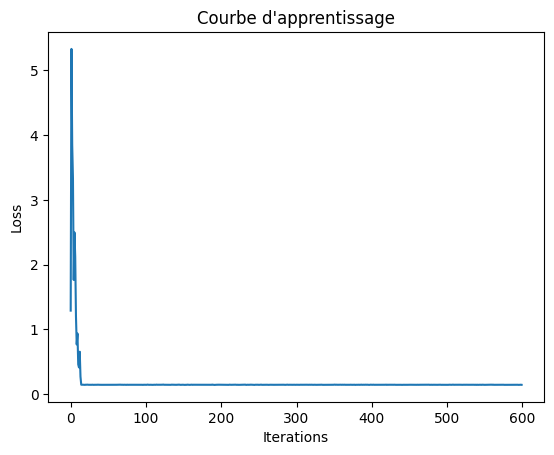

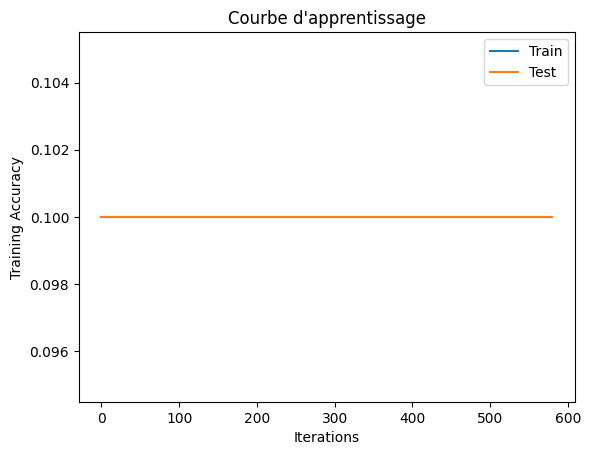

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.1
Meilleur Précision finale Test : 0.1
Training completed in 19.73 seconds
Training with batch size 32, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.07213620841503143
Acc Train: 0.10078125
Acc Test: 0.1
Epoch: 1
Loss: 0.07225645333528519
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.07201214134693146
Acc Train: 0.1
Acc Test: 0.1
Epoch: 3
Loss: 0.07226473093032837
Acc Train: 0.1
Acc Test: 0.1
Epoch: 4
Loss: 0.0729144811630249
Acc Train: 0.1
Acc Test: 0.1
Epoch: 5
Loss: 0.07276180386543274
Acc Train: 0.1
Acc Test: 0.1
Epoch: 6
Loss: 0.0724506676197052
Acc Train: 0.1
Acc Test: 0.1
Epoch: 7
Loss: 0.07178577035665512
Acc Train: 0.1
Acc Test: 0.1
Epoch: 8
Loss: 0.07194477319717407
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.07163000851869583
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.07178788632154465
Acc Train: 0.1
Acc Test: 0.1
Epoch: 11
Loss: 0.0727786272764206
Acc Train: 0.1
Acc Tes

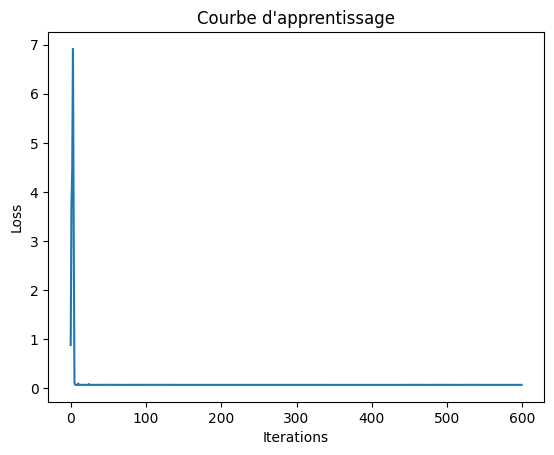

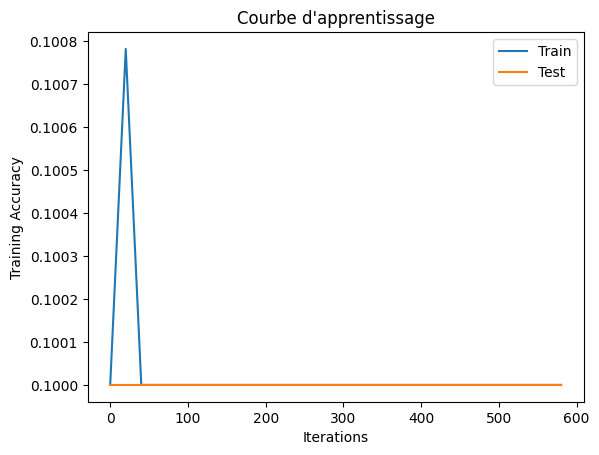

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.10078125
Meilleur Précision finale Test : 0.1
Training completed in 19.37 seconds
Training with batch size 32, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.1366819590330124
Acc Train: 0.17421875
Acc Test: 0.1
Epoch: 1
Loss: 0.07745400071144104
Acc Train: 0.2609375
Acc Test: 0.225
Epoch: 2
Loss: 0.06723006814718246
Acc Train: 0.34375
Acc Test: 0.25
Epoch: 3
Loss: 0.06534671783447266
Acc Train: 0.12265625
Acc Test: 0.0625
Epoch: 4
Loss: 0.06734123080968857
Acc Train: 0.1203125
Acc Test: 0.0625
Epoch: 5
Loss: 0.06185955926775932
Acc Train: 0.11796875
Acc Test: 0.05
Epoch: 6
Loss: 0.07185105234384537
Acc Train: 0.1125
Acc Test: 0.05
Epoch: 7
Loss: 0.06947941333055496
Acc Train: 0.109375
Acc Test: 0.0875
Epoch: 8
Loss: 0.07172481715679169
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.07186989486217499
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.07191301882266998
Acc Train: 0.1
Acc Test: 

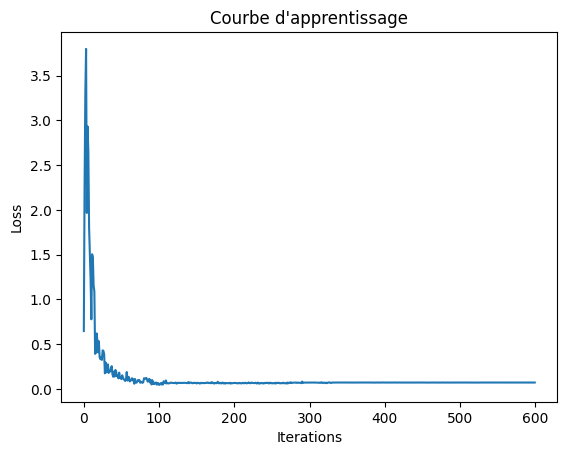

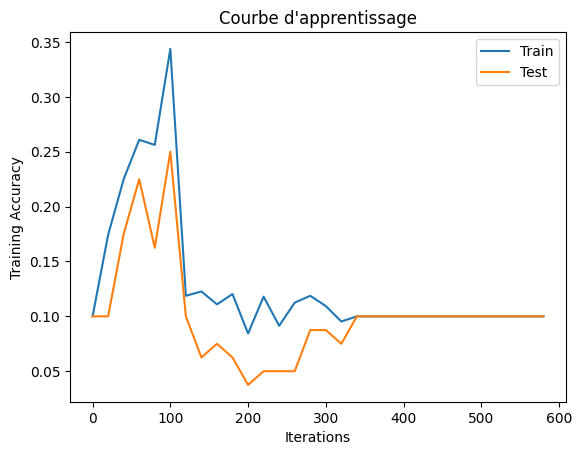

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.34375
Meilleur Précision finale Test : 0.25
Training completed in 19.31 seconds
Training with batch size 64, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.036189965903759
Acc Train: 0.1
Acc Test: 0.1
Epoch: 1
Loss: 0.03600999340415001
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.035706132650375366
Acc Train: 0.1
Acc Test: 0.1
Epoch: 3
Loss: 0.03580276668071747
Acc Train: 0.1
Acc Test: 0.1
Epoch: 4
Loss: 0.03570260852575302
Acc Train: 0.1
Acc Test: 0.1
Epoch: 5
Loss: 0.03594294190406799
Acc Train: 0.1
Acc Test: 0.1
Epoch: 6
Loss: 0.03588508442044258
Acc Train: 0.1
Acc Test: 0.1
Epoch: 7
Loss: 0.03600383177399635
Acc Train: 0.1
Acc Test: 0.1
Epoch: 8
Loss: 0.03594371676445007
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.035758063197135925
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.03617391362786293
Acc Train: 0.1
Acc Test: 0.1
Epoch: 11
Loss: 0.03573308885097504
Acc Train: 0.1
Acc Te

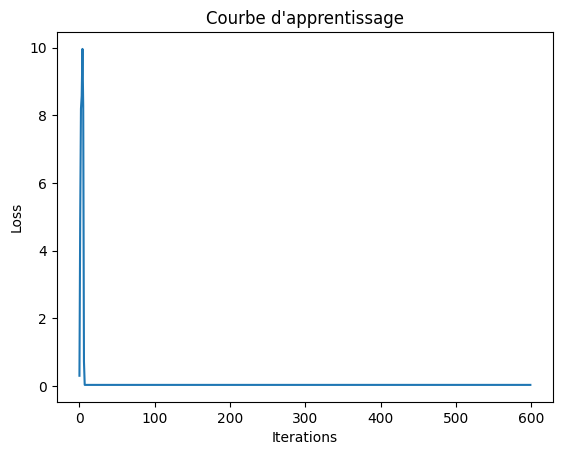

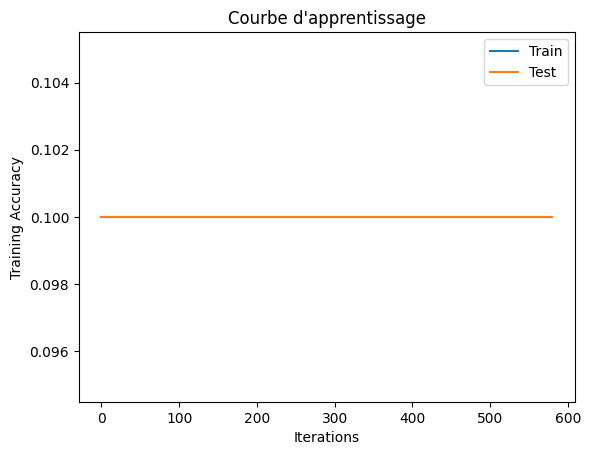

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.1
Meilleur Précision finale Test : 0.1
Training completed in 19.19 seconds
Training with batch size 64, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.03588278219103813
Acc Train: 0.12734375
Acc Test: 0.1375
Epoch: 1
Loss: 0.036035455763339996
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.036246273666620255
Acc Train: 0.1
Acc Test: 0.1
Epoch: 3
Loss: 0.035932645201683044
Acc Train: 0.1
Acc Test: 0.1
Epoch: 4
Loss: 0.0359383188188076
Acc Train: 0.1
Acc Test: 0.1
Epoch: 5
Loss: 0.03593870997428894
Acc Train: 0.1
Acc Test: 0.1
Epoch: 6
Loss: 0.03618505224585533
Acc Train: 0.1
Acc Test: 0.1
Epoch: 7
Loss: 0.03604825586080551
Acc Train: 0.1
Acc Test: 0.1
Epoch: 8
Loss: 0.03603954613208771
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.036002758890390396
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.03626316785812378
Acc Train: 0.1
Acc Test: 0.1
Epoch: 11
Loss: 0.035775329917669296
Acc Train: 

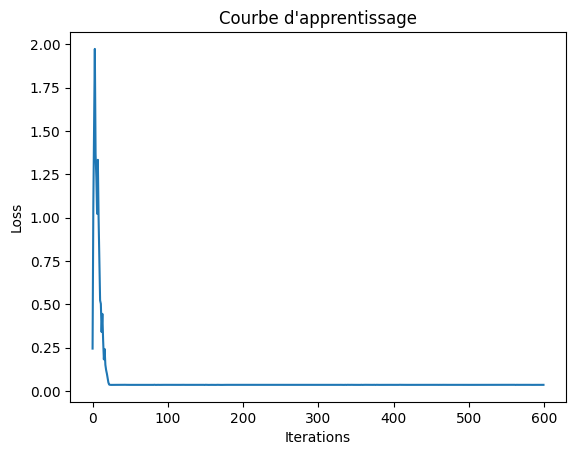

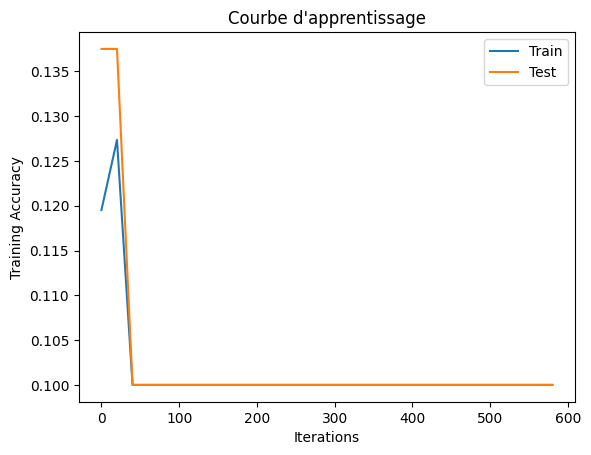

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.12734375
Meilleur Précision finale Test : 0.1375
Training completed in 19.78 seconds
Total computation time for all model trainings: 157.54 seconds
{'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.1, 'best_test_acc': 0.1, 'training_duration': 22.26235818862915}
{'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'adam', 'best_train_acc': 0.1, 'best_test_acc': 0.1, 'training_duration': 19.159159183502197}
{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.1, 'best_test_acc': 0.1, 'training_duration': 18.738694667816162}
{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'adam', 'best_train_acc': 0.1, 'best_test_acc': 0.1, 'training_duration': 19.725878953933716}
{'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.10078125, 'best_test_acc': 0.1, 'training_duration': 19.370584726333618}
{'b

In [33]:
# Define the parameter grid
batch_sizes = [8, 16, 32, 64]
learning_rates = [0.0001]
optimizers = ['sgd', 'adam']
# Define the number of epochs
num_epochs = 15
# Start measuring the total computation time
start_time = time.time()

# List to store results for each model training session
results = []
# Iterate over each combination of parameters
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            print(f"Training with batch size {batch_size}, learning rate {learning_rate}, optimizer {optimizer}")
            training_start_time = time.time()
            model = MLP()
            # Run training and get the best accuracies
            best_train_acc, best_test_acc = train(model, train_loader_all, test_loader, batch_size=batch_size, 
                                                  weight_decay=0.0, optimizer=optimizer, 
                                                  learning_rate=learning_rate, num_epochs=num_epochs)

            # Calculate and print the time taken for the current training session
            training_end_time = time.time()
            training_duration = training_end_time - training_start_time
            print(f"Training completed in {training_duration:.2f} seconds")

            # Store the results
            results.append({
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'optimizer': optimizer,
                'best_train_acc': best_train_acc,
                'best_test_acc': best_test_acc,
                'training_duration': training_duration
            })

# Calculate and print the total time taken for all training sessions
end_time = time.time()
print(f"Total computation time for all model trainings: {end_time - start_time:.2f} seconds")

# Optionally print all results
for result in results:
    print(result)

Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

In [25]:
model = MLP()
model.load_state_dict(device = torch.device("cuda" if torch.cuda.is_available() else "cpu")best_mlp1)
mat = matriceConfusion(model)
print(mat)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 7., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 8.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 8.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 8.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 8.],
        [0., 0., 0., 0., 0., 1., 1., 0., 6., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 6., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 8.],
        [0., 0., 0., 0., 0., 1., 0., 0., 7., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 8.]])


In [ ]:
all_predictions = []
model.eval()
for images, labels in test_loader:
  outputs = model(images)
  _, predictions = torch.max(outputs, 1)
  all_predictions.append(predictions.detach().numpy())
all_predictions = np.concatenate(all_predictions)


In [ ]:
np.unique(all_predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 4, 10, 10,  6,  4,  5, 15,  9, 10,  7]))

In [34]:
# Improved MLP model
class MLP_improved(nn.Module):
    def __init__(self):
        super(MLP_improved, self).__init__()
        self.fc1 = nn.Linear(input_size, 512, bias=False)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128, bias=False)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(128, output_size)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


In [30]:
model_improved = MLP_improved()
print(model_improved)

MLP_improved(
  (fc1): Linear(in_features=27648, out_features=512, bias=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=False)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [34]:
# Calculating total number of parameter
total_params_mlp2 = sum([p.numel() for p in model_improved.parameters()])
print(total_params_mlp2)

14322698


In [35]:
total_params_mlp2/total_params_mlp1

10.356552611789207

Training with batch size 8, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.27266255021095276
Acc Train: 0.1859375
Acc Test: 0.1625
Epoch: 1
Loss: 0.2648624777793884
Acc Train: 0.38828125
Acc Test: 0.3375
Epoch: 2
Loss: 0.24801914393901825
Acc Train: 0.465625
Acc Test: 0.3875
Epoch: 3
Loss: 0.23184913396835327
Acc Train: 0.5390625
Acc Test: 0.525
Epoch: 4
Loss: 0.21976877748966217
Acc Train: 0.5921875
Acc Test: 0.55
Epoch: 5
Loss: 0.20913521945476532
Acc Train: 0.603125
Acc Test: 0.575
Epoch: 6
Loss: 0.2176542580127716
Acc Train: 0.63203125
Acc Test: 0.55
Epoch: 7
Loss: 0.2264881283044815
Acc Train: 0.6546875
Acc Test: 0.575
Epoch: 8
Loss: 0.21989141404628754
Acc Train: 0.6703125
Acc Test: 0.5625
Epoch: 9
Loss: 0.2053632289171219
Acc Train: 0.6796875
Acc Test: 0.575
Epoch: 10
Loss: 0.17535606026649475
Acc Train: 0.68125
Acc Test: 0.5875
Epoch: 11
Loss: 0.21143588423728943
Acc Train: 0.7109375
Acc Test: 0.6125
Epoch: 12
Loss: 0.21333172917366028
Acc Train: 0.7140625
Acc Test: 0.637

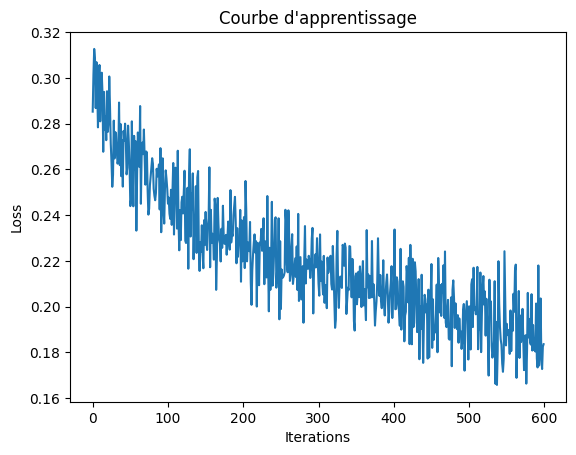

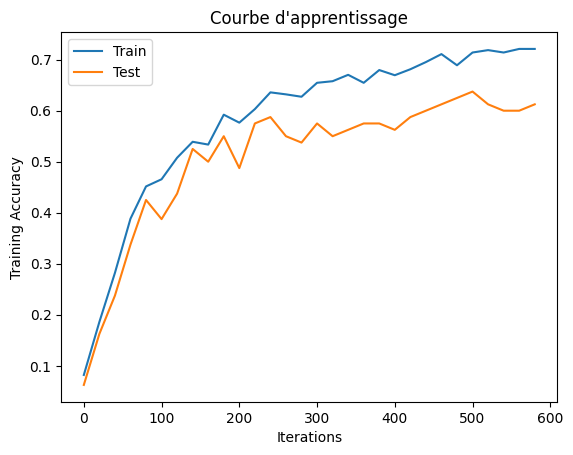

Précision finale Train : 0.72109375
Précision finale Test : 0.6125
Meilleur Précision finale Train : 0.72109375
Meilleur Précision finale Test : 0.6375
Training completed in 22.72 seconds
Training with batch size 8, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.24814599752426147
Acc Train: 0.34140625
Acc Test: 0.25
Epoch: 1
Loss: 0.25056517124176025
Acc Train: 0.53046875
Acc Test: 0.5125
Epoch: 2
Loss: 0.20738133788108826
Acc Train: 0.62109375
Acc Test: 0.575
Epoch: 3
Loss: 0.2263369858264923
Acc Train: 0.65078125
Acc Test: 0.575
Epoch: 4
Loss: 0.1871911883354187
Acc Train: 0.6484375
Acc Test: 0.6
Epoch: 5
Loss: 0.16714927554130554
Acc Train: 0.7203125
Acc Test: 0.7125
Epoch: 6
Loss: 0.1574074625968933
Acc Train: 0.69921875
Acc Test: 0.6
Epoch: 7
Loss: 0.15794335305690765
Acc Train: 0.72109375
Acc Test: 0.6375
Epoch: 8
Loss: 0.14821387827396393
Acc Train: 0.74375
Acc Test: 0.6625
Epoch: 9
Loss: 0.14525118470191956
Acc Train: 0.7671875
Acc Test: 0.6875
Epoch: 10
Loss: 0.12688732

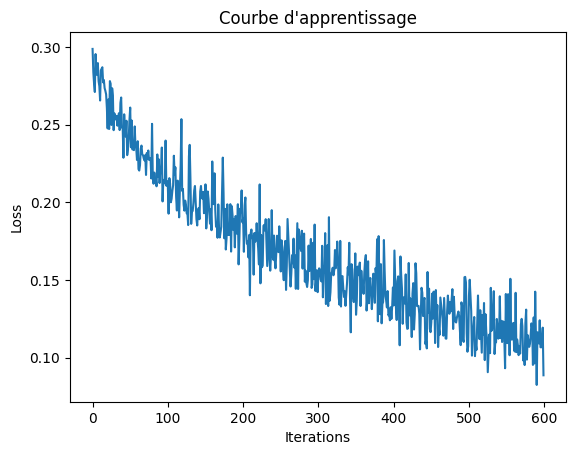

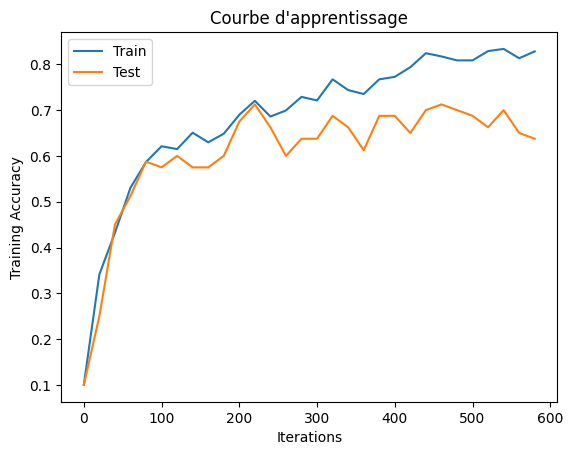

Précision finale Train : 0.828125
Précision finale Test : 0.6375
Meilleur Précision finale Train : 0.83359375
Meilleur Précision finale Test : 0.7125
Training completed in 24.15 seconds
Training with batch size 16, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.13605548441410065
Acc Train: 0.14296875
Acc Test: 0.1
Epoch: 1
Loss: 0.12975424528121948
Acc Train: 0.3828125
Acc Test: 0.45
Epoch: 2
Loss: 0.1254725158214569
Acc Train: 0.53984375
Acc Test: 0.5125
Epoch: 3
Loss: 0.12000018358230591
Acc Train: 0.62265625
Acc Test: 0.6125
Epoch: 4
Loss: 0.12299519777297974
Acc Train: 0.62109375
Acc Test: 0.5875
Epoch: 5
Loss: 0.11845037341117859
Acc Train: 0.65625
Acc Test: 0.6625
Epoch: 6
Loss: 0.1110057681798935
Acc Train: 0.65
Acc Test: 0.6
Epoch: 7
Loss: 0.12296188622713089
Acc Train: 0.68828125
Acc Test: 0.6625
Epoch: 8
Loss: 0.10053998976945877
Acc Train: 0.71328125
Acc Test: 0.65
Epoch: 9
Loss: 0.1072721928358078
Acc Train: 0.71953125
Acc Test: 0.6
Epoch: 10
Loss: 0.09816071391105652

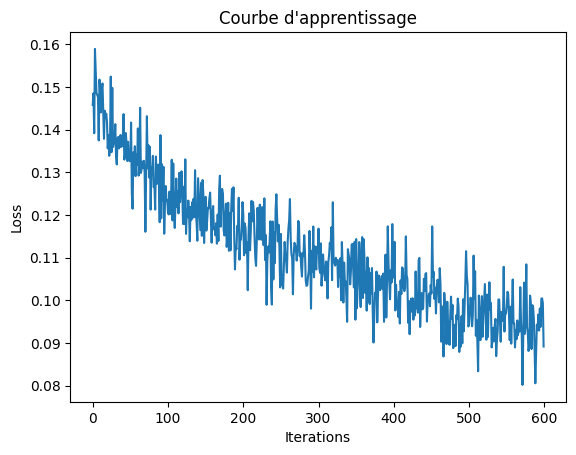

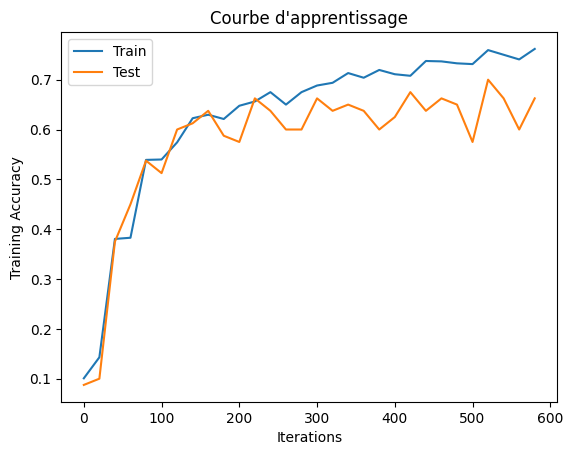

Précision finale Train : 0.76171875
Précision finale Test : 0.6625
Meilleur Précision finale Train : 0.76171875
Meilleur Précision finale Test : 0.7
Training completed in 22.30 seconds
Training with batch size 16, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.12589070200920105
Acc Train: 0.28203125
Acc Test: 0.2875
Epoch: 1
Loss: 0.1151859313249588
Acc Train: 0.48125
Acc Test: 0.4625
Epoch: 2
Loss: 0.10177144408226013
Acc Train: 0.5921875
Acc Test: 0.5625
Epoch: 3
Loss: 0.09417548775672913
Acc Train: 0.64375
Acc Test: 0.6
Epoch: 4
Loss: 0.08070292323827744
Acc Train: 0.678125
Acc Test: 0.65
Epoch: 5
Loss: 0.0774826928973198
Acc Train: 0.65703125
Acc Test: 0.5625
Epoch: 6
Loss: 0.08620402216911316
Acc Train: 0.71171875
Acc Test: 0.6375
Epoch: 7
Loss: 0.06478124111890793
Acc Train: 0.71796875
Acc Test: 0.6375
Epoch: 8
Loss: 0.0908568799495697
Acc Train: 0.7140625
Acc Test: 0.6375
Epoch: 9
Loss: 0.0651724636554718
Acc Train: 0.76328125
Acc Test: 0.7125
Epoch: 10
Loss: 0.0643031969

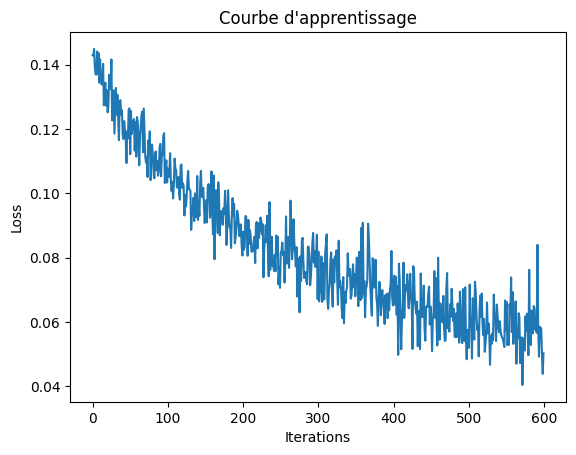

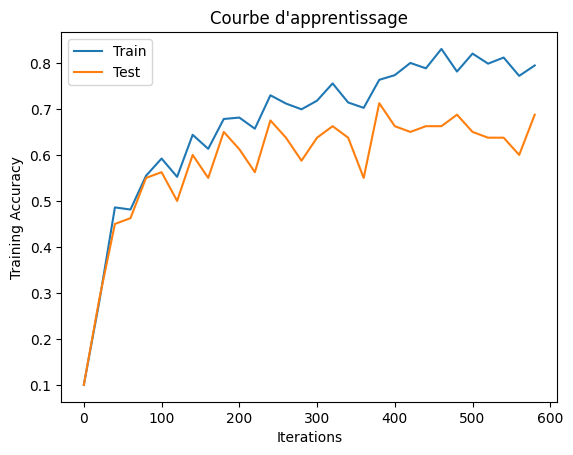

Précision finale Train : 0.79453125
Précision finale Test : 0.6875
Meilleur Précision finale Train : 0.83046875
Meilleur Précision finale Test : 0.7125
Training completed in 24.24 seconds
Training with batch size 32, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.06862981617450714
Acc Train: 0.1828125
Acc Test: 0.2
Epoch: 1
Loss: 0.05931553244590759
Acc Train: 0.52265625
Acc Test: 0.5
Epoch: 2
Loss: 0.05817870423197746
Acc Train: 0.54453125
Acc Test: 0.5375
Epoch: 3
Loss: 0.060064490884542465
Acc Train: 0.63359375
Acc Test: 0.575
Epoch: 4
Loss: 0.06214248389005661
Acc Train: 0.6265625
Acc Test: 0.55
Epoch: 5
Loss: 0.0578731894493103
Acc Train: 0.66875
Acc Test: 0.5875
Epoch: 6
Loss: 0.05063125863671303
Acc Train: 0.67265625
Acc Test: 0.5875
Epoch: 7
Loss: 0.05052323266863823
Acc Train: 0.675
Acc Test: 0.6125
Epoch: 8
Loss: 0.050956226885318756
Acc Train: 0.69765625
Acc Test: 0.6
Epoch: 9
Loss: 0.05467544123530388
Acc Train: 0.69140625
Acc Test: 0.6125
Epoch: 10
Loss: 0.0482194162

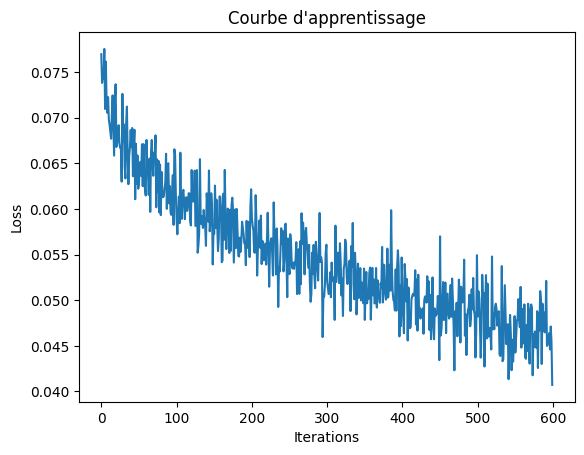

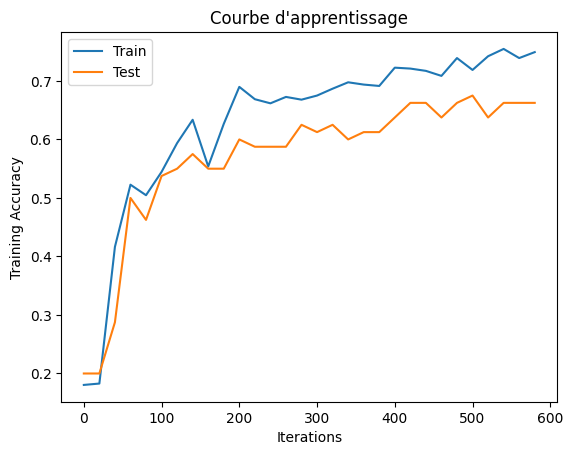

Précision finale Train : 0.74921875
Précision finale Test : 0.6625
Meilleur Précision finale Train : 0.7546875
Meilleur Précision finale Test : 0.675
Training completed in 22.85 seconds
Training with batch size 32, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.05931563302874565
Acc Train: 0.275
Acc Test: 0.2875
Epoch: 1
Loss: 0.057176895439624786
Acc Train: 0.5703125
Acc Test: 0.5
Epoch: 2
Loss: 0.04851518198847771
Acc Train: 0.6296875
Acc Test: 0.575
Epoch: 3
Loss: 0.04562848433852196
Acc Train: 0.6734375
Acc Test: 0.625
Epoch: 4
Loss: 0.0394415482878685
Acc Train: 0.67890625
Acc Test: 0.65
Epoch: 5
Loss: 0.05025358125567436
Acc Train: 0.67109375
Acc Test: 0.6
Epoch: 6
Loss: 0.03648705780506134
Acc Train: 0.7015625
Acc Test: 0.6125
Epoch: 7
Loss: 0.043507881462574005
Acc Train: 0.73046875
Acc Test: 0.675
Epoch: 8
Loss: 0.04014033079147339
Acc Train: 0.7421875
Acc Test: 0.6125
Epoch: 9
Loss: 0.03375602141022682
Acc Train: 0.75078125
Acc Test: 0.625
Epoch: 10
Loss: 0.03770959004

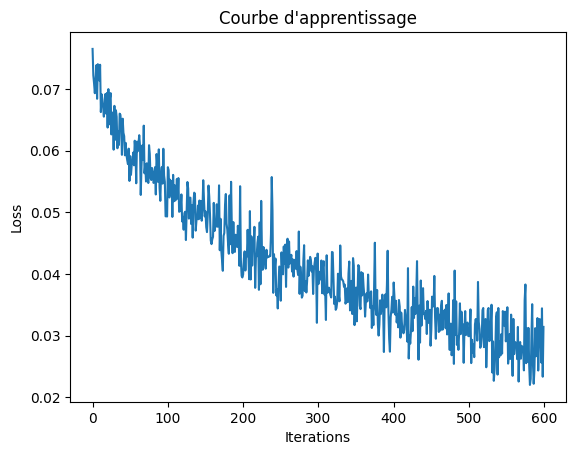

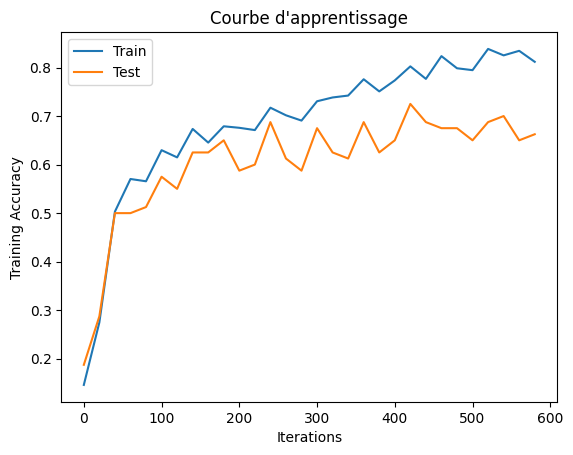

Précision finale Train : 0.81171875
Précision finale Test : 0.6625
Meilleur Précision finale Train : 0.83828125
Meilleur Précision finale Test : 0.725
Training completed in 24.04 seconds
Training with batch size 64, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.03470658138394356
Acc Train: 0.15859375
Acc Test: 0.2
Epoch: 1
Loss: 0.03145792335271835
Acc Train: 0.30859375
Acc Test: 0.25
Epoch: 2
Loss: 0.02782304584980011
Acc Train: 0.4265625
Acc Test: 0.325
Epoch: 3
Loss: 0.030065061524510384
Acc Train: 0.553125
Acc Test: 0.5375
Epoch: 4
Loss: 0.028632182627916336
Acc Train: 0.51796875
Acc Test: 0.5
Epoch: 5
Loss: 0.02852698788046837
Acc Train: 0.57421875
Acc Test: 0.5625
Epoch: 6
Loss: 0.027924280613660812
Acc Train: 0.6453125
Acc Test: 0.625
Epoch: 7
Loss: 0.027967005968093872
Acc Train: 0.6390625
Acc Test: 0.5625
Epoch: 8
Loss: 0.02649589441716671
Acc Train: 0.6578125
Acc Test: 0.625
Epoch: 9
Loss: 0.023801038041710854
Acc Train: 0.6875
Acc Test: 0.6125
Epoch: 10
Loss: 0.023346

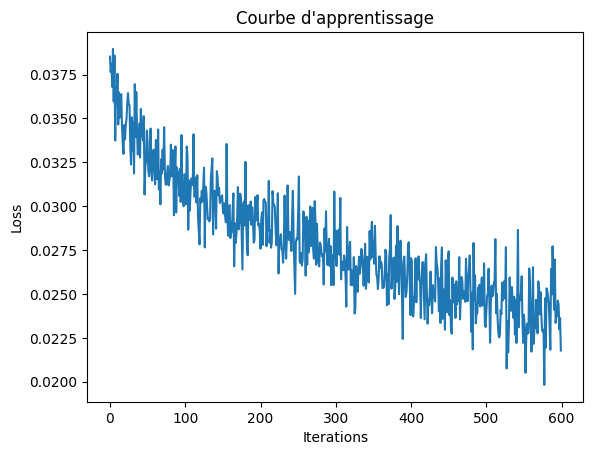

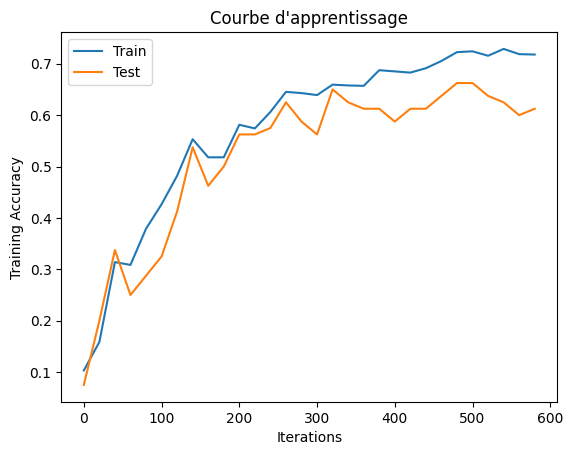

Précision finale Train : 0.71796875
Précision finale Test : 0.6125
Meilleur Précision finale Train : 0.72890625
Meilleur Précision finale Test : 0.6625
Training completed in 22.55 seconds
Training with batch size 64, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.030113469809293747
Acc Train: 0.2453125
Acc Test: 0.2375
Epoch: 1
Loss: 0.029476497322320938
Acc Train: 0.51953125
Acc Test: 0.4875
Epoch: 2
Loss: 0.02386143058538437
Acc Train: 0.61875
Acc Test: 0.575
Epoch: 3
Loss: 0.028049366548657417
Acc Train: 0.61875
Acc Test: 0.5625
Epoch: 4
Loss: 0.022659432142972946
Acc Train: 0.6921875
Acc Test: 0.6625
Epoch: 5
Loss: 0.02090936340391636
Acc Train: 0.72578125
Acc Test: 0.675
Epoch: 6
Loss: 0.01981852948665619
Acc Train: 0.7359375
Acc Test: 0.675
Epoch: 7
Loss: 0.019254619255661964
Acc Train: 0.734375
Acc Test: 0.6125
Epoch: 8
Loss: 0.02280469611287117
Acc Train: 0.75234375
Acc Test: 0.6
Epoch: 9
Loss: 0.01685830019414425
Acc Train: 0.7625
Acc Test: 0.6625
Epoch: 10
Loss: 0.0156

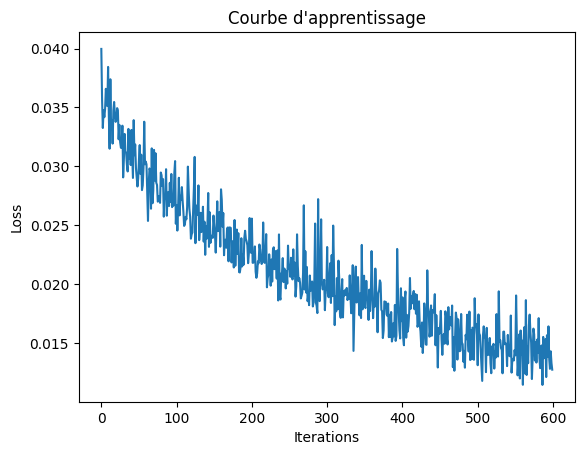

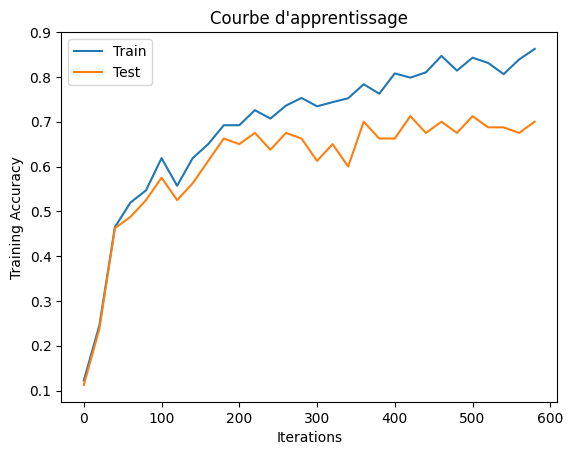

Précision finale Train : 0.8625
Précision finale Test : 0.7
Meilleur Précision finale Train : 0.8625
Meilleur Précision finale Test : 0.7125
Training completed in 24.90 seconds
Total computation time for all model trainings: 187.75 seconds
{'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.72109375, 'best_test_acc': 0.6375, 'training_duration': 22.720289707183838}
{'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'adam', 'best_train_acc': 0.83359375, 'best_test_acc': 0.7125, 'training_duration': 24.14958667755127}
{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.76171875, 'best_test_acc': 0.7, 'training_duration': 22.29578161239624}
{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'adam', 'best_train_acc': 0.83046875, 'best_test_acc': 0.7125, 'training_duration': 24.23740577697754}
{'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.7546875, 'best_test_acc': 0.675, 'training

In [35]:
# Define the parameter grid
batch_sizes = [8, 16, 32, 64]
learning_rates = [0.0001]
optimizers = ['sgd', 'adam']
# Define the number of epochs
num_epochs = 15
# Start measuring the total computation time
start_time = time.time()

# List to store results for each model training session
results = []
# Iterate over each combination of parameters
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            print(f"Training with batch size {batch_size}, learning rate {learning_rate}, optimizer {optimizer}")
            training_start_time = time.time()
            model = MLP_improved()
            # Run training and get the best accuracies
            best_train_acc, best_test_acc = train(model, train_loader_all, test_loader, batch_size=batch_size, 
                                                  weight_decay=0.0, optimizer=optimizer, 
                                                  learning_rate=learning_rate, num_epochs=num_epochs)

            # Calculate and print the time taken for the current training session
            training_end_time = time.time()
            training_duration = training_end_time - training_start_time
            print(f"Training completed in {training_duration:.2f} seconds")

            # Store the results
            results.append({
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'optimizer': optimizer,
                'best_train_acc': best_train_acc,
                'best_test_acc': best_test_acc,
                'training_duration': training_duration
            })

# Calculate and print the total time taken for all training sessions
end_time = time.time()
print(f"Total computation time for all model trainings: {end_time - start_time:.2f} seconds")

# Optionally print all results
for result in results:
    print(result)

In [ ]:
model = MLP_improved()
model.load_state_dict(best_mlp2)
mat = matriceConfusion(model)
print(mat)

tensor([[3., 0., 0., 0., 0., 1., 1., 0., 3., 0.],

        [0., 6., 0., 1., 0., 1., 0., 0., 0., 0.],

        [0., 0., 6., 1., 0., 0., 1., 0., 0., 0.],

        [0., 0., 0., 7., 0., 0., 1., 0., 0., 0.],

        [0., 1., 0., 0., 3., 2., 0., 1., 0., 1.],

        [0., 0., 0., 0., 0., 3., 4., 0., 1., 0.],

        [2., 0., 0., 0., 0., 0., 6., 0., 0., 0.],

        [0., 0., 0., 0., 0., 0., 0., 6., 0., 2.],

        [0., 0., 0., 0., 0., 2., 0., 0., 6., 0.],

        [0., 1., 0., 0., 0., 0., 0., 0., 0., 7.]])


On voit que le MLP n'est pas performant. Vous pourrez durant le temps que vous avez pour préparer le rapport essayer de modifier son architecture pour tenter d'améliorer ses performances.


Passons à un réseau convolutif, un CNN.

Compléter son implémentation ci-dessous pour définir trois couches de convolution avec des noyaux de taille 3x3 et à 8, 16 et 32 canaux en sortie respectivement.

Compléter les dimensions qui vont bien pour les deux couches fully-connected fc1 et fc2. fc1 a 50 neurones et fc2 10 neurones pour les 10 classes.

Une ReLU sera appliquée après chaque couche de convolution et après fc1.

Le pooling s'applique après chaque couche de convolution.

Compléter la méthode forward. Vous pouvez afficher les dimensions de la sortie de la dernière couche de convolution, après le pooling, pour déterminer la dimension que vous devez règler pour la couche fc1.


In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,8,3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16,32,3)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32*14*25, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1,32*14*25) # flatten
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x


Instancier le modèle CNN et afficher son nombre de paramètres

Training with batch size 8, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.2807919383049011
Acc Train: 0.13671875
Acc Test: 0.1375
Epoch: 1
Loss: 0.260901540517807
Acc Train: 0.2828125
Acc Test: 0.25
Epoch: 2
Loss: 0.21860510110855103
Acc Train: 0.37578125
Acc Test: 0.275
Epoch: 3
Loss: 0.19667334854602814
Acc Train: 0.4171875
Acc Test: 0.3125
Epoch: 4
Loss: 0.2758527398109436
Acc Train: 0.3484375
Acc Test: 0.3375
Epoch: 5
Loss: 0.17165549099445343
Acc Train: 0.4984375
Acc Test: 0.4
Epoch: 6
Loss: 0.2548094093799591
Acc Train: 0.5296875
Acc Test: 0.4125
Epoch: 7
Loss: 0.22560513019561768
Acc Train: 0.4671875
Acc Test: 0.325
Epoch: 8
Loss: 0.2094532698392868
Acc Train: 0.56484375
Acc Test: 0.4375
Epoch: 9
Loss: 0.16091661155223846
Acc Train: 0.66015625
Acc Test: 0.5375
Epoch: 10
Loss: 0.13747526705265045
Acc Train: 0.6859375
Acc Test: 0.475
Epoch: 11
Loss: 0.12272872775793076
Acc Train: 0.63984375
Acc Test: 0.4125
Epoch: 12
Loss: 0.10152323544025421
Acc Train: 0.63984375
Acc Test:

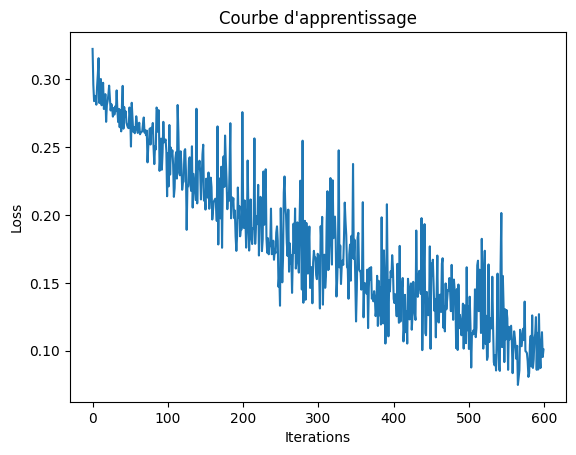

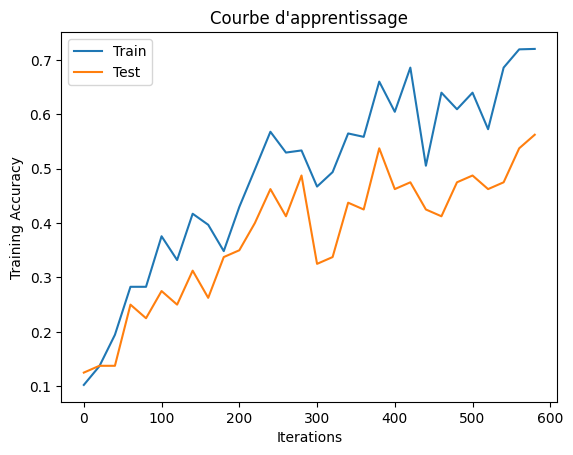

Précision finale Train : 0.7203125
Précision finale Test : 0.5625
Meilleur Précision finale Train : 0.7203125
Meilleur Précision finale Test : 0.5625
Training completed in 24.90 seconds
Training with batch size 8, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.27931028604507446
Acc Train: 0.15234375
Acc Test: 0.125
Epoch: 1
Loss: 0.28302714228630066
Acc Train: 0.140625
Acc Test: 0.15
Epoch: 2
Loss: 0.26686230301856995
Acc Train: 0.1453125
Acc Test: 0.1375
Epoch: 3
Loss: 0.2771494686603546
Acc Train: 0.19609375
Acc Test: 0.175
Epoch: 4
Loss: 0.2707425653934479
Acc Train: 0.18125
Acc Test: 0.175
Epoch: 5
Loss: 0.26930102705955505
Acc Train: 0.16640625
Acc Test: 0.15
Epoch: 6
Loss: 0.26838746666908264
Acc Train: 0.190625
Acc Test: 0.2
Epoch: 7
Loss: 0.2631140351295471
Acc Train: 0.2484375
Acc Test: 0.2125
Epoch: 8
Loss: 0.24925445020198822
Acc Train: 0.271875
Acc Test: 0.225
Epoch: 9
Loss: 0.2540578246116638
Acc Train: 0.28359375
Acc Test: 0.2625
Epoch: 10
Loss: 0.24332399666309357

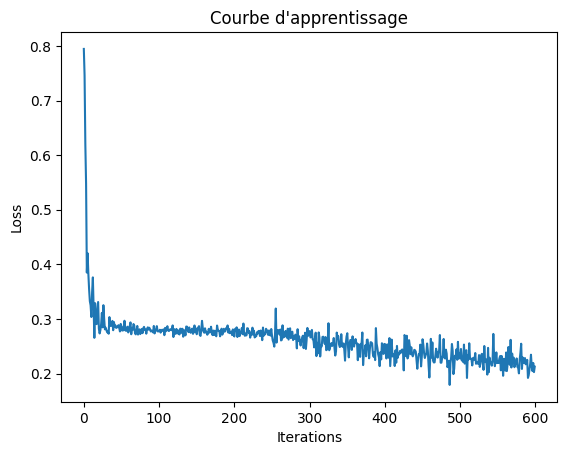

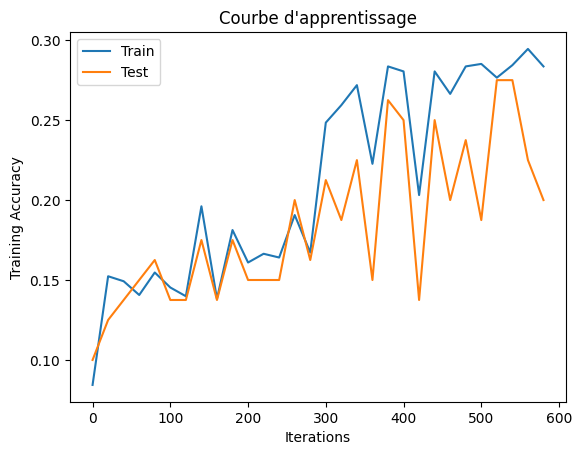

Précision finale Train : 0.28359375
Précision finale Test : 0.2
Meilleur Précision finale Train : 0.29453125
Meilleur Précision finale Test : 0.275
Training completed in 24.94 seconds
Training with batch size 16, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.14056752622127533
Acc Train: 0.1140625
Acc Test: 0.125
Epoch: 1
Loss: 0.1317187398672104
Acc Train: 0.146875
Acc Test: 0.1875
Epoch: 2
Loss: 0.11906242370605469
Acc Train: 0.28125
Acc Test: 0.325
Epoch: 3
Loss: 0.12348096072673798
Acc Train: 0.34921875
Acc Test: 0.3125
Epoch: 4
Loss: 0.1294490247964859
Acc Train: 0.384375
Acc Test: 0.3375
Epoch: 5
Loss: 0.111513152718544
Acc Train: 0.26875
Acc Test: 0.2625
Epoch: 6
Loss: 0.11717161536216736
Acc Train: 0.4140625
Acc Test: 0.3
Epoch: 7
Loss: 0.07994493842124939
Acc Train: 0.43125
Acc Test: 0.3625
Epoch: 8
Loss: 0.09545352309942245
Acc Train: 0.434375
Acc Test: 0.3375
Epoch: 9
Loss: 0.08068738132715225
Acc Train: 0.5625
Acc Test: 0.3875
Epoch: 10
Loss: 0.08670136332511902
Acc T

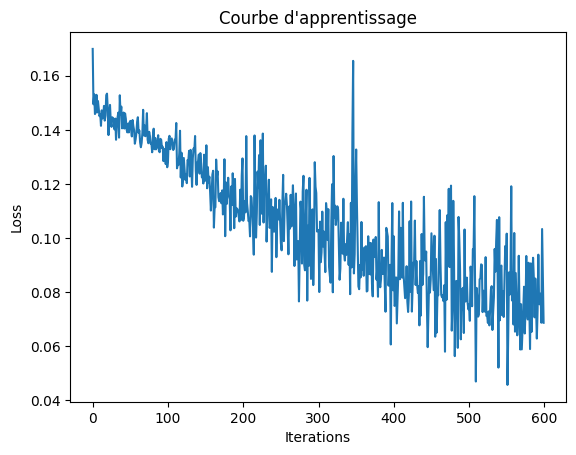

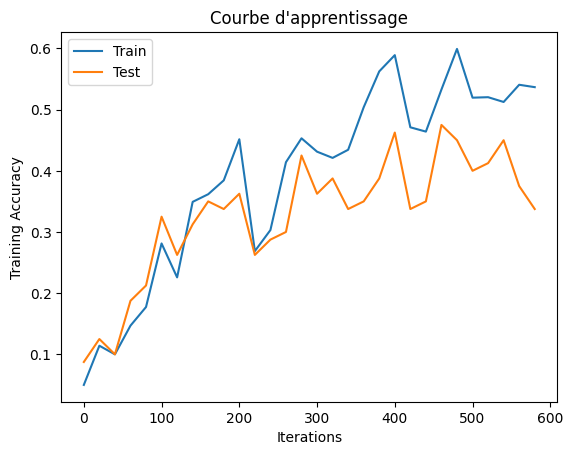

Précision finale Train : 0.53671875
Précision finale Test : 0.3375
Meilleur Précision finale Train : 0.59921875
Meilleur Précision finale Test : 0.475
Training completed in 24.88 seconds
Training with batch size 16, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.1337888389825821
Acc Train: 0.1359375
Acc Test: 0.15
Epoch: 1
Loss: 0.10649082809686661
Acc Train: 0.25703125
Acc Test: 0.2125
Epoch: 2
Loss: 0.10791486501693726
Acc Train: 0.47734375
Acc Test: 0.375
Epoch: 3
Loss: 0.07795023918151855
Acc Train: 0.6015625
Acc Test: 0.4625
Epoch: 4
Loss: 0.08378028124570847
Acc Train: 0.56796875
Acc Test: 0.425
Epoch: 5
Loss: 0.06528133898973465
Acc Train: 0.721875
Acc Test: 0.525
Epoch: 6
Loss: 0.05803193897008896
Acc Train: 0.71640625
Acc Test: 0.5
Epoch: 7
Loss: 0.05823471397161484
Acc Train: 0.78125
Acc Test: 0.5125
Epoch: 8
Loss: 0.039317354559898376
Acc Train: 0.759375
Acc Test: 0.5125
Epoch: 9
Loss: 0.04308555647730827
Acc Train: 0.7484375
Acc Test: 0.5125
Epoch: 10
Loss: 0.0488751

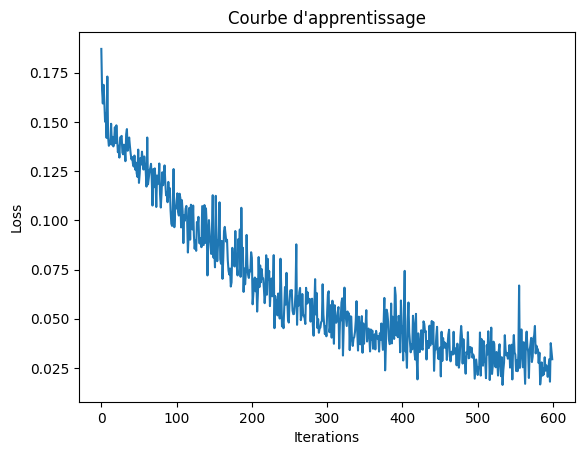

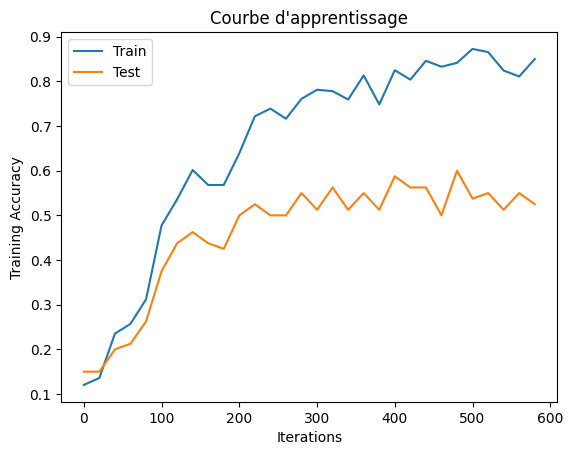

Précision finale Train : 0.85
Précision finale Test : 0.525
Meilleur Précision finale Train : 0.87265625
Meilleur Précision finale Test : 0.6
Training completed in 24.85 seconds
Training with batch size 32, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.07177859544754028
Acc Train: 0.10546875
Acc Test: 0.1
Epoch: 1
Loss: 0.06047610193490982
Acc Train: 0.1484375
Acc Test: 0.125
Epoch: 2
Loss: 0.05785859003663063
Acc Train: 0.23828125
Acc Test: 0.25
Epoch: 3
Loss: 0.05121009796857834
Acc Train: 0.38125
Acc Test: 0.275
Epoch: 4
Loss: 0.059226397424936295
Acc Train: 0.44140625
Acc Test: 0.3
Epoch: 5
Loss: 0.0453929528594017
Acc Train: 0.53359375
Acc Test: 0.3375
Epoch: 6
Loss: 0.041431158781051636
Acc Train: 0.55859375
Acc Test: 0.4
Epoch: 7
Loss: 0.030468331649899483
Acc Train: 0.5703125
Acc Test: 0.5
Epoch: 8
Loss: 0.03020237572491169
Acc Train: 0.61796875
Acc Test: 0.55
Epoch: 9
Loss: 0.031205149367451668
Acc Train: 0.64453125
Acc Test: 0.5
Epoch: 10
Loss: 0.03251998499035835
Acc 

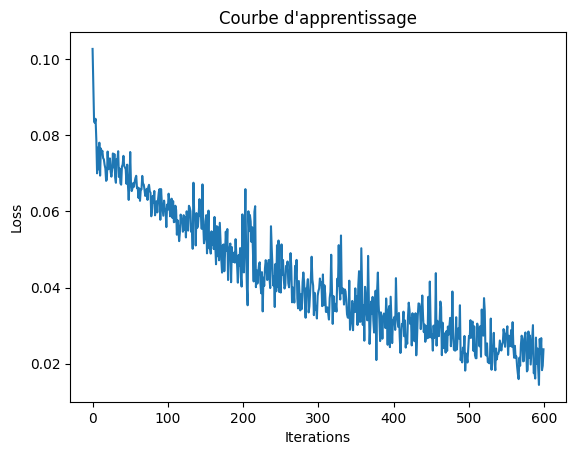

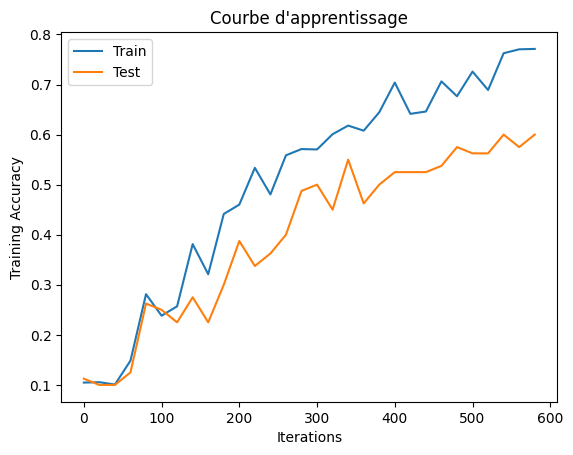

Précision finale Train : 0.77109375
Précision finale Test : 0.6
Meilleur Précision finale Train : 0.77109375
Meilleur Précision finale Test : 0.6
Training completed in 24.83 seconds
Training with batch size 32, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.0708983764052391
Acc Train: 0.1015625
Acc Test: 0.1
Epoch: 1
Loss: 0.07272112369537354
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.07157929241657257
Acc Train: 0.1
Acc Test: 0.1
Epoch: 3
Loss: 0.0728277936577797
Acc Train: 0.1
Acc Test: 0.1
Epoch: 4
Loss: 0.0719817653298378
Acc Train: 0.1
Acc Test: 0.1
Epoch: 5
Loss: 0.07296023517847061
Acc Train: 0.1
Acc Test: 0.1
Epoch: 6
Loss: 0.07283761352300644
Acc Train: 0.1
Acc Test: 0.1
Epoch: 7
Loss: 0.07237941771745682
Acc Train: 0.1
Acc Test: 0.1
Epoch: 8
Loss: 0.07189944386482239
Acc Train: 0.1
Acc Test: 0.1
Epoch: 9
Loss: 0.07202959060668945
Acc Train: 0.1
Acc Test: 0.1
Epoch: 10
Loss: 0.07214763015508652
Acc Train: 0.1
Acc Test: 0.1
Epoch: 11
Loss: 0.07225850969552994
Acc Trai

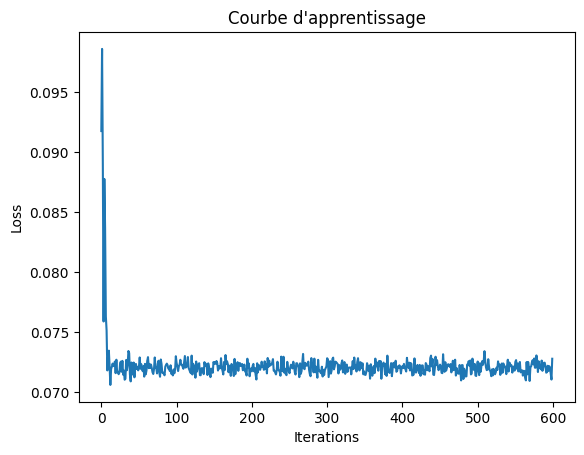

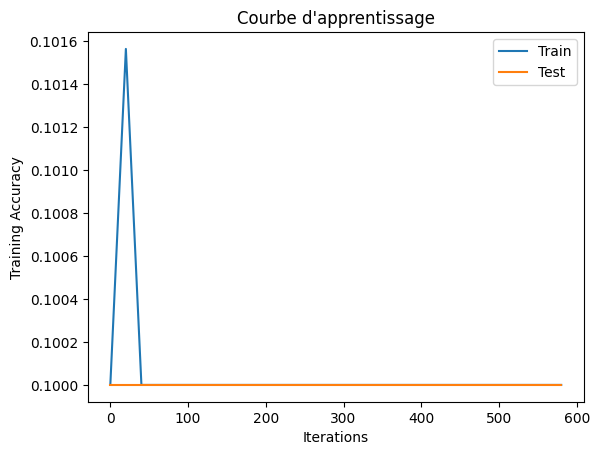

Précision finale Train : 0.1
Précision finale Test : 0.1
Meilleur Précision finale Train : 0.1015625
Meilleur Précision finale Test : 0.1
Training completed in 25.06 seconds
Training with batch size 64, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.03201793506741524
Acc Train: 0.16015625
Acc Test: 0.1375
Epoch: 1
Loss: 0.031103922054171562
Acc Train: 0.19765625
Acc Test: 0.2
Epoch: 2
Loss: 0.02864154428243637
Acc Train: 0.33359375
Acc Test: 0.275
Epoch: 3
Loss: 0.02641771361231804
Acc Train: 0.37421875
Acc Test: 0.2875
Epoch: 4
Loss: 0.027007631957530975
Acc Train: 0.375
Acc Test: 0.35
Epoch: 5
Loss: 0.01985161565244198
Acc Train: 0.359375
Acc Test: 0.3125
Epoch: 6
Loss: 0.021304873749613762
Acc Train: 0.5671875
Acc Test: 0.4125
Epoch: 7
Loss: 0.02875049039721489
Acc Train: 0.5265625
Acc Test: 0.4125
Epoch: 8
Loss: 0.017988089472055435
Acc Train: 0.47890625
Acc Test: 0.4
Epoch: 9
Loss: 0.01886068470776081
Acc Train: 0.59609375
Acc Test: 0.525
Epoch: 10
Loss: 0.018636837601661682

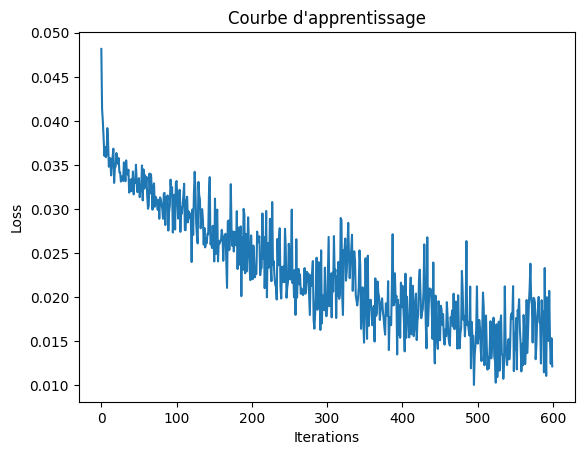

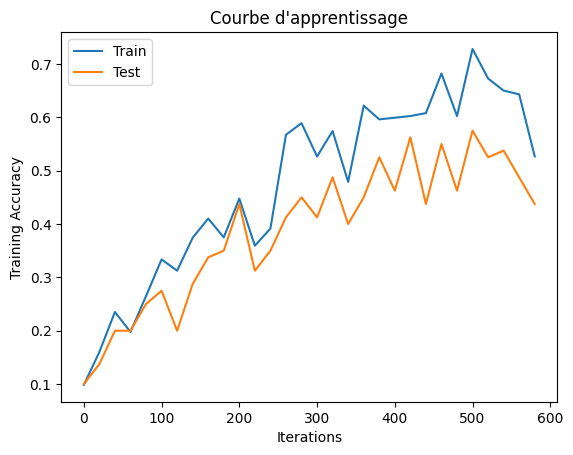

Précision finale Train : 0.5265625
Précision finale Test : 0.4375
Meilleur Précision finale Train : 0.728125
Meilleur Précision finale Test : 0.575
Training completed in 25.04 seconds
Training with batch size 64, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.032040778547525406
Acc Train: 0.203125
Acc Test: 0.2125
Epoch: 1
Loss: 0.026651998981833458
Acc Train: 0.459375
Acc Test: 0.4625
Epoch: 2
Loss: 0.021966133266687393
Acc Train: 0.55390625
Acc Test: 0.475
Epoch: 3
Loss: 0.017465291544795036
Acc Train: 0.5609375
Acc Test: 0.5375
Epoch: 4
Loss: 0.014245466329157352
Acc Train: 0.646875
Acc Test: 0.5
Epoch: 5
Loss: 0.017808860167860985
Acc Train: 0.7109375
Acc Test: 0.5375
Epoch: 6
Loss: 0.013421069830656052
Acc Train: 0.73515625
Acc Test: 0.5875
Epoch: 7
Loss: 0.010475153103470802
Acc Train: 0.7703125
Acc Test: 0.6625
Epoch: 8
Loss: 0.007010255940258503
Acc Train: 0.82578125
Acc Test: 0.65
Epoch: 9
Loss: 0.00619853101670742
Acc Train: 0.81875
Acc Test: 0.6375
Epoch: 10
Loss: 0.0

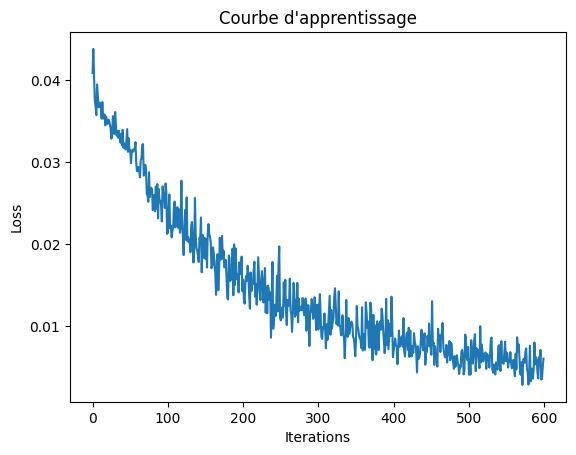

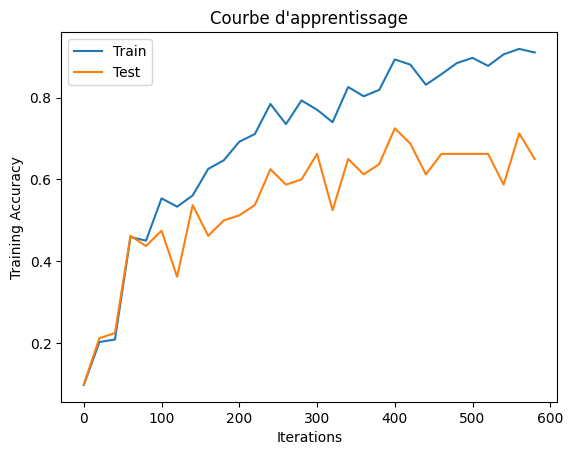

Précision finale Train : 0.91015625
Précision finale Test : 0.65
Meilleur Précision finale Train : 0.91875
Meilleur Précision finale Test : 0.725
Training completed in 25.24 seconds
Total computation time for all model trainings: 199.73 seconds
{'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.7203125, 'best_test_acc': 0.5625, 'training_duration': 24.903041124343872}
{'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'adam', 'best_train_acc': 0.29453125, 'best_test_acc': 0.275, 'training_duration': 24.940856456756592}
{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.59921875, 'best_test_acc': 0.475, 'training_duration': 24.879653215408325}
{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'adam', 'best_train_acc': 0.87265625, 'best_test_acc': 0.6, 'training_duration': 24.845882892608643}
{'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.77109375, 'best_test_acc': 0.6, 'trai

In [39]:
# Define the parameter grid
batch_sizes = [8, 16, 32, 64]
learning_rates = [0.0001]
optimizers = ['sgd', 'adam']
# Define the number of epochs
num_epochs = 15
# Start measuring the total computation time
start_time = time.time()

# List to store results for each model training session
results = []
# Iterate over each combination of parameters
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            print(f"Training with batch size {batch_size}, learning rate {learning_rate}, optimizer {optimizer}")
            training_start_time = time.time()
            model = CNN()
            # Run training and get the best accuracies
            best_train_acc, best_test_acc = train(model, train_loader_all, test_loader, batch_size=batch_size, 
                                                  weight_decay=0.0, optimizer=optimizer, 
                                                  learning_rate=learning_rate, num_epochs=num_epochs)

            # Calculate and print the time taken for the current training session
            training_end_time = time.time()
            training_duration = training_end_time - training_start_time
            print(f"Training completed in {training_duration:.2f} seconds")

            # Store the results
            results.append({
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'optimizer': optimizer,
                'best_train_acc': best_train_acc,
                'best_test_acc': best_test_acc,
                'training_duration': training_duration
            })

# Calculate and print the total time taken for all training sessions
end_time = time.time()
print(f"Total computation time for all model trainings: {end_time - start_time:.2f} seconds")

# Optionally print all results
for result in results:
    print(result)

Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([16, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([16, 32, 14, 25])

Epoch: 0

Loss: 0.07226040214300156

Acc Train: 0.1

Acc Test: 0.1

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

torch.Size([32, 32, 14, 25])

to

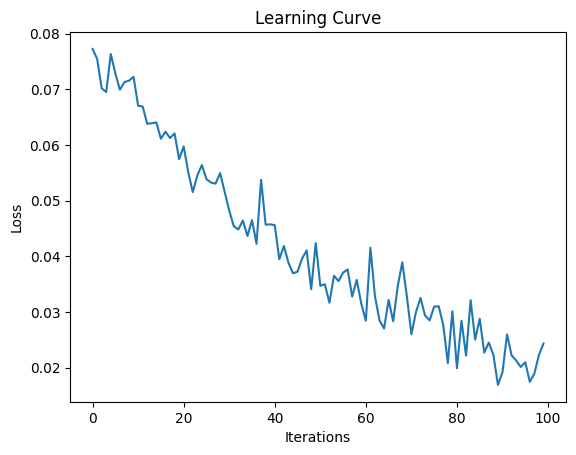

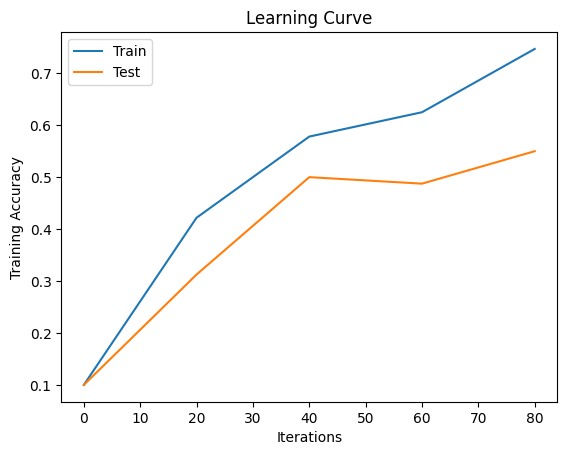

Final Training Accuracy: 0.746875

Final Test Accuracy: 0.55


In [ ]:
best_cnn1 = train_return_best_model(model, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=10)

In [41]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)


        self.dropout = nn.Dropout(0.5)


        self.fc1 = nn.Linear(13312, 512)
        self.fc2 = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 13312)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [34]:
model = ComplexCNN()
print(model)

ComplexCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=13312, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [35]:
128*8*13

13312

# Test on original dataset

Epoch: 0
Loss: 0.05136023461818695
Acc Train: 0.1
Acc Test: 0.1
Epoch: 1
Loss: 0.03767363727092743
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.022915631532669067
Acc Train: 0.696875
Acc Test: 0.6625
Epoch: 3
Loss: 0.017348352819681168
Acc Train: 0.696875
Acc Test: 0.6625
Epoch: 4
Loss: 0.01343542616814375
Acc Train: 0.828125
Acc Test: 0.75
Epoch: 5
Loss: 0.014863819815218449
Acc Train: 0.828125
Acc Test: 0.75
Epoch: 6
Loss: 0.010594652034342289
Acc Train: 0.90625
Acc Test: 0.75
Epoch: 7
Loss: 0.009429741650819778
Acc Train: 0.90625
Acc Test: 0.75
Epoch: 8
Loss: 0.008887947537004948
Acc Train: 0.9375
Acc Test: 0.825
Epoch: 9
Loss: 0.012121140025556087
Acc Train: 0.9375
Acc Test: 0.825


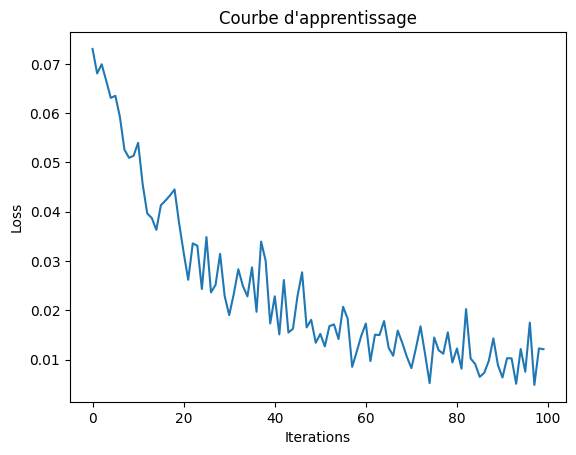

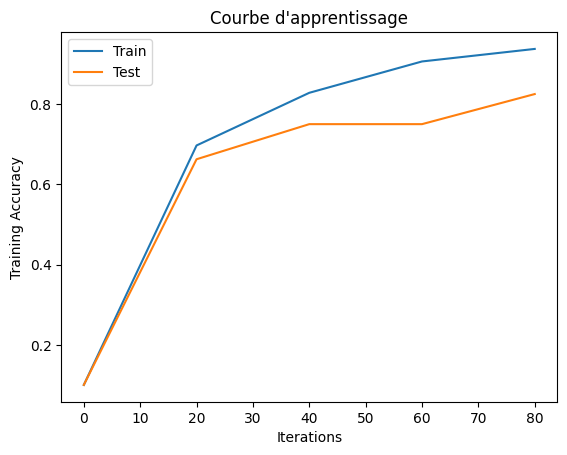

Précision finale Train : 0.9375
Précision finale Test : 0.825


In [36]:
train(model,train_loader,test_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=10)

# Training on augmented Dataset with TS methode, the test loader remains the same as the original one

Epoch: 0
Loss: 0.04645247384905815
Acc Train: 0.1
Acc Test: 0.1
Epoch: 1
Loss: 0.028795011341571808
Acc Train: 0.5296875
Acc Test: 0.5125
Epoch: 2
Loss: 0.016339950263500214
Acc Train: 0.79375
Acc Test: 0.75
Epoch: 3
Loss: 0.01857186295092106
Acc Train: 0.846875
Acc Test: 0.7625
Epoch: 4
Loss: 0.01661493070423603
Acc Train: 0.8828125
Acc Test: 0.7875
Epoch: 5
Loss: 0.006105601787567139
Acc Train: 0.8921875
Acc Test: 0.8
Epoch: 6
Loss: 0.010049150325357914
Acc Train: 0.915625
Acc Test: 0.75
Epoch: 7
Loss: 0.012336972169578075
Acc Train: 0.9375
Acc Test: 0.8
Epoch: 8
Loss: 0.00810991320759058
Acc Train: 0.9625
Acc Test: 0.7625
Epoch: 9
Loss: 0.007649932522326708
Acc Train: 0.971875
Acc Test: 0.8
Epoch: 10
Loss: 0.005554165691137314
Acc Train: 0.9796875
Acc Test: 0.7875
Epoch: 11
Loss: 0.004584835842251778
Acc Train: 0.9875
Acc Test: 0.8125
Epoch: 12
Loss: 0.002057171193882823
Acc Train: 0.971875
Acc Test: 0.75
Epoch: 13
Loss: 0.004956897348165512
Acc Train: 0.9828125
Acc Test: 0.7875
Epo

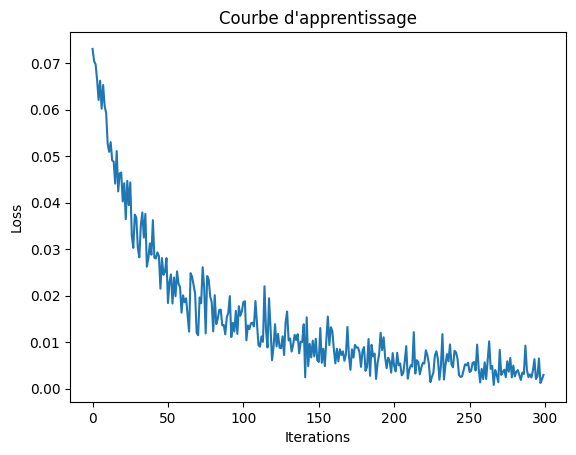

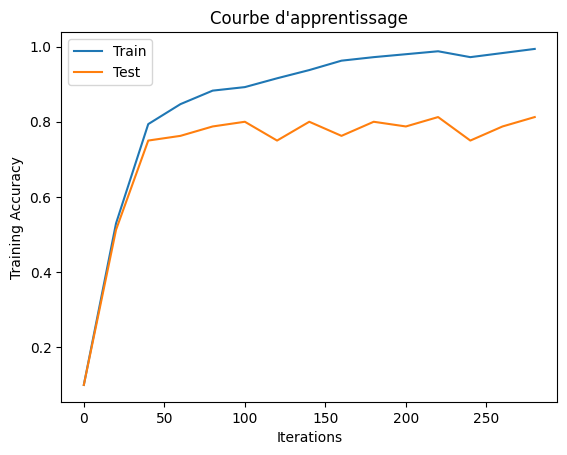

Précision finale Train : 0.99375
Précision finale Test : 0.8125
Meilleur Précision finale Train : 0.99375
Meilleur Précision finale Test : 0.8125


(0.99375, 0.8125)

In [42]:
model = ComplexCNN()
train(model,train_loader_ts,test_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=15)

Epoch: 0
Loss: 0.04537562280893326
Acc Train: 0.1015625
Acc Test: 0.1
Epoch: 1
Loss: 0.02100227400660515
Acc Train: 0.6734375
Acc Test: 0.65
Epoch: 2
Loss: 0.022143971174955368
Acc Train: 0.7375
Acc Test: 0.725
Epoch: 3
Loss: 0.012557578273117542
Acc Train: 0.771875
Acc Test: 0.725
Epoch: 4
Loss: 0.01337790209800005
Acc Train: 0.86875
Acc Test: 0.7625
Epoch: 5
Loss: 0.008800099603831768
Acc Train: 0.878125
Acc Test: 0.7375
Epoch: 6
Loss: 0.006744049955159426
Acc Train: 0.9453125
Acc Test: 0.8
Epoch: 7
Loss: 0.003120649605989456
Acc Train: 0.959375
Acc Test: 0.8125
Epoch: 8
Loss: 0.002452135318890214
Acc Train: 0.9671875
Acc Test: 0.8375
Epoch: 9
Loss: 0.006513835862278938
Acc Train: 0.98125
Acc Test: 0.85
Epoch: 10
Loss: 0.008001155219972134
Acc Train: 0.9859375
Acc Test: 0.8375
Epoch: 11
Loss: 0.0017965937731787562
Acc Train: 0.975
Acc Test: 0.825
Epoch: 12
Loss: 0.0030088128987699747
Acc Train: 0.9890625
Acc Test: 0.85
Epoch: 13
Loss: 0.009933052584528923
Acc Train: 0.9828125
Acc Tes

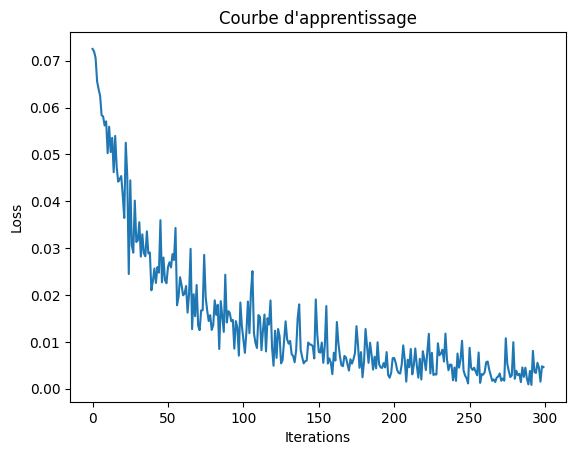

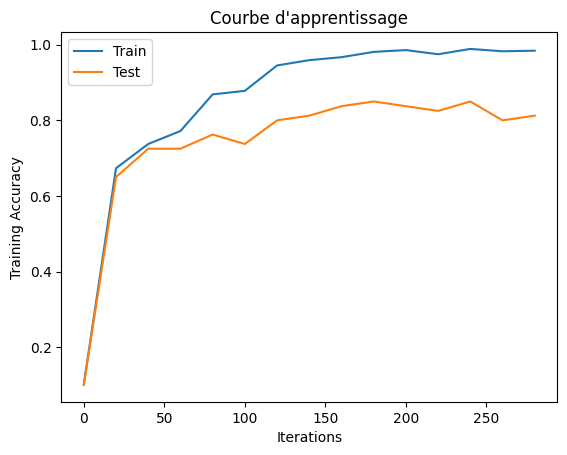

Précision finale Train : 0.984375
Précision finale Test : 0.8125
Meilleur Précision finale Train : 0.9890625
Meilleur Précision finale Test : 0.85


(0.9890625, 0.85)

In [43]:
model = ComplexCNN()
train(model,train_loader_ts,tmodel = ComplexCNN()
train(model,train_loader_ts,test_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=15)est_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=15)

Epoch: 0
Loss: 0.0266815647482872
Acc Train: 0.603125
Acc Test: 0.6
Epoch: 1
Loss: 0.024459995329380035
Acc Train: 0.7822916666666667
Acc Test: 0.7375
Epoch: 2
Loss: 0.01699138432741165
Acc Train: 0.871875
Acc Test: 0.7625
Epoch: 3
Loss: 0.009083305485546589
Acc Train: 0.8927083333333333
Acc Test: 0.7
Epoch: 4
Loss: 0.009831422939896584
Acc Train: 0.9625
Acc Test: 0.8
Epoch: 5
Loss: 0.0034214206971228123
Acc Train: 0.95
Acc Test: 0.8125
Epoch: 6
Loss: 0.007827727124094963
Acc Train: 0.9625
Acc Test: 0.8125
Epoch: 7
Loss: 0.0021896727848798037
Acc Train: 0.96875
Acc Test: 0.7875
Epoch: 8
Loss: 0.0036070323549211025
Acc Train: 0.9833333333333333
Acc Test: 0.8
Epoch: 9
Loss: 0.0063929189927875996
Acc Train: 0.9864583333333333
Acc Test: 0.85
Epoch: 10
Loss: 0.0017530815675854683
Acc Train: 0.9895833333333334
Acc Test: 0.85
Epoch: 11
Loss: 0.007615921553224325
Acc Train: 0.9875
Acc Test: 0.825
Epoch: 12
Loss: 0.0028220999520272017
Acc Train: 0.9916666666666667
Acc Test: 0.85
Epoch: 13
Loss:

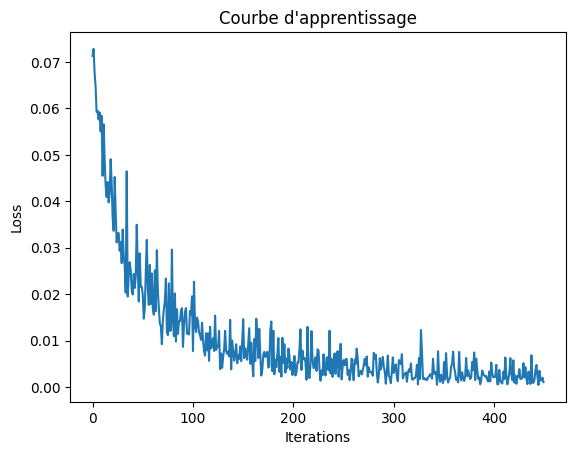

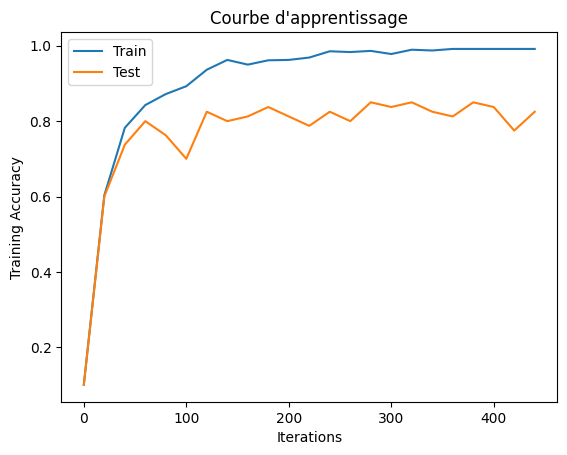

Précision finale Train : 0.9916666666666667
Précision finale Test : 0.825
Meilleur Précision finale Train : 0.9916666666666667
Meilleur Précision finale Test : 0.85


(0.9916666666666667, 0.85)

In [44]:
model = ComplexCNN()
train(model,train_loader_ps,test_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=15)

Epoch: 0
Loss: 0.031219514086842537
Acc Train: 0.4796875
Acc Test: 0.4625
Epoch: 1
Loss: 0.019270174205303192
Acc Train: 0.8234375
Acc Test: 0.725
Epoch: 2
Loss: 0.011521290987730026
Acc Train: 0.88046875
Acc Test: 0.75
Epoch: 3
Loss: 0.01035153679549694
Acc Train: 0.94921875
Acc Test: 0.8125
Epoch: 4
Loss: 0.003934129141271114
Acc Train: 0.9703125
Acc Test: 0.7875
Epoch: 5
Loss: 0.0051521542482078075
Acc Train: 0.95078125
Acc Test: 0.8375
Epoch: 6
Loss: 0.008404279127717018
Acc Train: 0.96875
Acc Test: 0.825
Epoch: 7
Loss: 0.0039055917877703905
Acc Train: 0.98359375
Acc Test: 0.825
Epoch: 8
Loss: 0.002086659660562873
Acc Train: 0.9890625
Acc Test: 0.825
Epoch: 9
Loss: 0.0017317695310339332
Acc Train: 0.99140625
Acc Test: 0.8
Epoch: 10
Loss: 0.000650449248496443
Acc Train: 0.99140625
Acc Test: 0.825
Epoch: 11
Loss: 0.0026708415243774652
Acc Train: 0.99296875
Acc Test: 0.825
Epoch: 12
Loss: 0.010415829718112946
Acc Train: 0.9921875
Acc Test: 0.8
Epoch: 13
Loss: 0.0013842799235135317
Acc

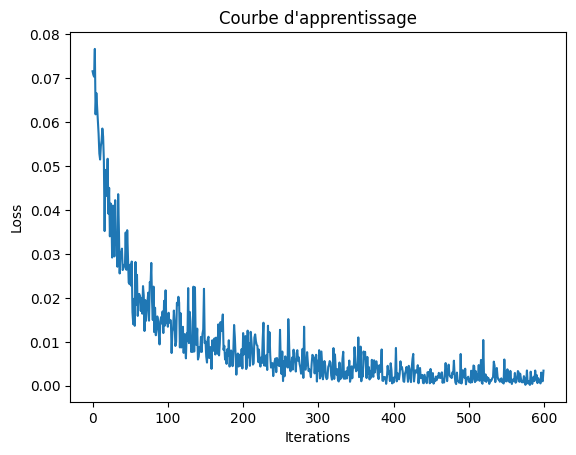

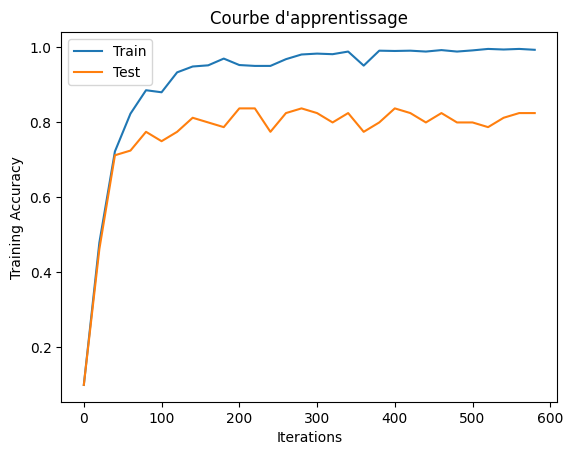

Précision finale Train : 0.99375
Précision finale Test : 0.825
Meilleur Précision finale Train : 0.99609375
Meilleur Précision finale Test : 0.8375


(0.99609375, 0.8375)

In [45]:
model = ComplexCNN()
train(model,train_loader_all,test_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=15)

# Training on augmented Dataset with PS methods, the test loader remains the same as the original one

Epoch: 0
Loss: 0.04213225841522217
Acc Train: 0.4875
Acc Test: 0.5375
Epoch: 1
Loss: 0.024182530120015144
Acc Train: 0.7583333333333333
Acc Test: 0.725
Epoch: 2
Loss: 0.014827027916908264
Acc Train: 0.8895833333333333
Acc Test: 0.75
Epoch: 3
Loss: 0.011630161665380001
Acc Train: 0.890625
Acc Test: 0.8125
Epoch: 4
Loss: 0.021785497665405273
Acc Train: 0.9375
Acc Test: 0.7875
Epoch: 5
Loss: 0.010006381198763847
Acc Train: 0.9645833333333333
Acc Test: 0.775
Epoch: 6
Loss: 0.015504764392971992
Acc Train: 0.9697916666666667
Acc Test: 0.8125
Epoch: 7
Loss: 0.005158072803169489
Acc Train: 0.9739583333333334
Acc Test: 0.7875
Epoch: 8
Loss: 0.0020147175528109074
Acc Train: 0.971875
Acc Test: 0.8
Epoch: 9
Loss: 0.004428677260875702
Acc Train: 0.978125
Acc Test: 0.8375
Epoch: 10
Loss: 0.002196303801611066
Acc Train: 0.984375
Acc Test: 0.8125
Epoch: 11
Loss: 0.0045896670781075954
Acc Train: 0.9854166666666667
Acc Test: 0.825
Epoch: 12
Loss: 0.002227185294032097
Acc Train: 0.9864583333333333
Acc Te

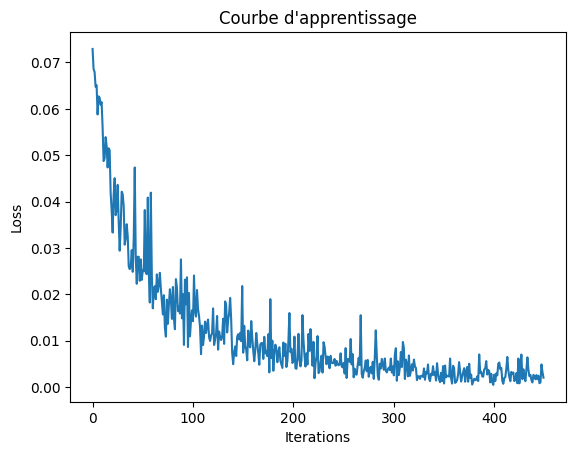

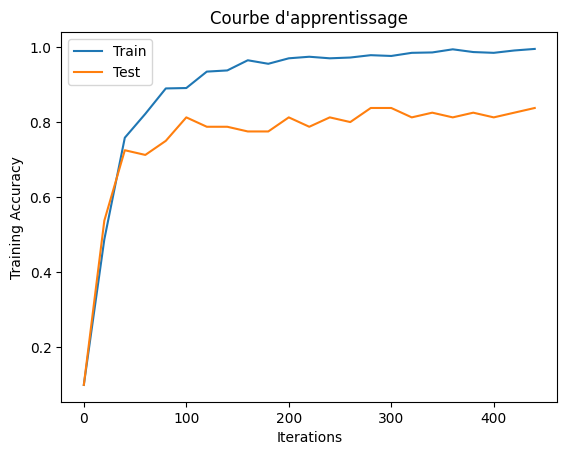

Précision finale Train : 0.9947916666666666
Précision finale Test : 0.8375


In [40]:
model = ComplexCNN()
train(model,train_loader_ps,test_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=15)

# Training on augmented Dataset with TS + PS methods, the test loader remains the same as the original one

Epoch: 0
Loss: 0.03312664479017258
Acc Train: 0.44921875
Acc Test: 0.425
Epoch: 1
Loss: 0.019910262897610664
Acc Train: 0.8265625
Acc Test: 0.775
Epoch: 2
Loss: 0.010412982665002346
Acc Train: 0.90703125
Acc Test: 0.8125
Epoch: 3
Loss: 0.0074170175939798355
Acc Train: 0.9046875
Acc Test: 0.775
Epoch: 4
Loss: 0.007076144218444824
Acc Train: 0.9140625
Acc Test: 0.7125
Epoch: 5
Loss: 0.005636281333863735
Acc Train: 0.94453125
Acc Test: 0.7625
Epoch: 6
Loss: 0.00573222478851676
Acc Train: 0.95625
Acc Test: 0.8125
Epoch: 7
Loss: 0.0028062080964446068
Acc Train: 0.978125
Acc Test: 0.8
Epoch: 8
Loss: 0.004650404676795006
Acc Train: 0.98125
Acc Test: 0.775
Epoch: 9
Loss: 0.0014271008549258113
Acc Train: 0.9890625
Acc Test: 0.8125
Epoch: 10
Loss: 0.004613339900970459
Acc Train: 0.9765625
Acc Test: 0.75
Epoch: 11
Loss: 0.0032048781868070364
Acc Train: 0.978125
Acc Test: 0.775
Epoch: 12
Loss: 0.00198064255528152
Acc Train: 0.99609375
Acc Test: 0.825
Epoch: 13
Loss: 0.000773891806602478
Acc Train:

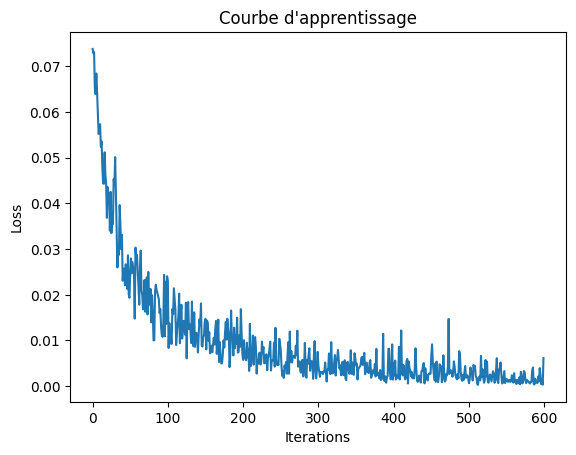

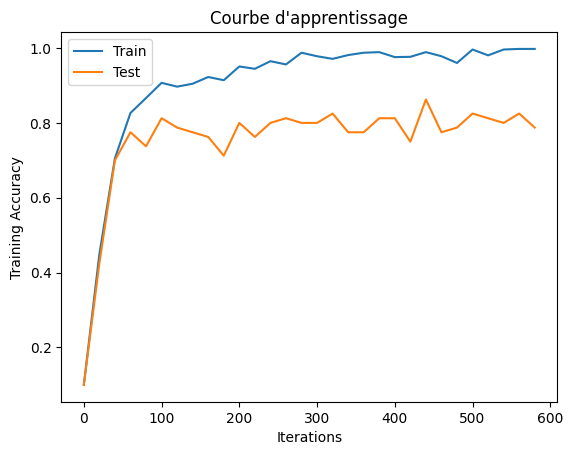

Précision finale Train : 0.99765625
Précision finale Test : 0.7875


In [41]:
model = ComplexCNN()
train(model,train_loader_all,test_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=15)

# BATCH SIZE 64

In [40]:
model = ComplexCNN()
train(model,train_loader_all,test_loader, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=15)

NameError: name 'ComplexCNN' is not defined

# Grid search 

In [47]:
import time

In [ ]:
# Start measuring the total computation time
start_time = time.time()

# List to store results for each model training session
results = []
# Iterate over each combination of parameters
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            print(f"Training with batch size {batch_size}, learning rate {learning_rate}, optimizer {optimizer}")
            training_start_time = time.time()
            model = ComplexCNN()
            # Run training and get the best accuracies
            best_train_acc, best_test_acc = train(model, train_loader_all, test_loader, batch_size=batch_size, 
                                                  weight_decay=0.0, optimizer=optimizer, 
                                                  learning_rate=learning_rate, num_epochs=num_epochs)

            # Calculate and print the time taken for the current training session
            training_end_time = time.time()
            training_duration = training_end_time - training_start_time
            print(f"Training completed in {training_duration:.2f} seconds")

            # Store the results
            results.append({
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'optimizer': optimizer,
                'best_train_acc': best_train_acc,
                'best_test_acc': best_test_acc,
                'training_duration': training_duration
            })

# Calculate and print the total time taken for all training sessions
end_time = time.time()
print(f"Total computation time for all model trainings: {end_time - start_time:.2f} seconds")

# Optionally print all results
for result in results:
    print(result)

In [51]:
# Start measuring the total computation time
start_time = time.time()

# List to store results for each model training session
results = []

Training with batch size 8, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.27209097146987915
Acc Train: 0.20390625
Acc Test: 0.2
Epoch: 1
Loss: 0.2588615417480469
Acc Train: 0.4171875
Acc Test: 0.325
Epoch: 2
Loss: 0.22283867001533508
Acc Train: 0.5984375
Acc Test: 0.5875
Epoch: 3
Loss: 0.20422106981277466
Acc Train: 0.6453125
Acc Test: 0.6625
Epoch: 4
Loss: 0.2021861970424652
Acc Train: 0.64140625
Acc Test: 0.625
Epoch: 5
Loss: 0.200311079621315
Acc Train: 0.7
Acc Test: 0.7125
Epoch: 6
Loss: 0.16891087591648102
Acc Train: 0.71796875
Acc Test: 0.725
Epoch: 7
Loss: 0.15122197568416595
Acc Train: 0.73671875
Acc Test: 0.7
Epoch: 8
Loss: 0.12769818305969238
Acc Train: 0.75703125
Acc Test: 0.75
Epoch: 9
Loss: 0.11864790320396423
Acc Train: 0.77265625
Acc Test: 0.7625
Epoch: 10
Loss: 0.13126738369464874
Acc Train: 0.7890625
Acc Test: 0.7625
Epoch: 11
Loss: 0.11289005726575851
Acc Train: 0.80390625
Acc Test: 0.75
Epoch: 12
Loss: 0.09243816137313843
Acc Train: 0.815625
Acc Test: 0.75
Epo

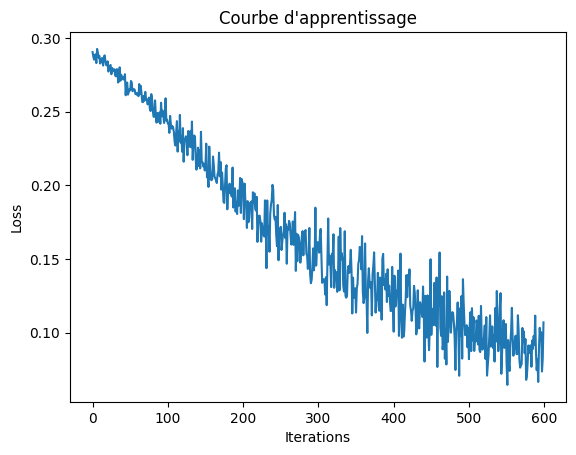

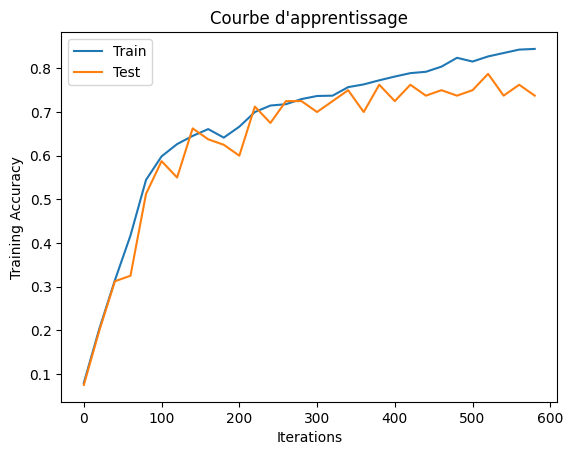

Précision finale Train : 0.84453125
Précision finale Test : 0.7375
Meilleur Précision finale Train : 0.84453125
Meilleur Précision finale Test : 0.7875
Training completed in 54.52 seconds
Training with batch size 8, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.08020399510860443
Acc Train: 0.58515625
Acc Test: 0.5875
Epoch: 1
Loss: 0.0556812547147274
Acc Train: 0.840625
Acc Test: 0.775
Epoch: 2
Loss: 0.05248652398586273
Acc Train: 0.86640625
Acc Test: 0.7625
Epoch: 3
Loss: 0.03344523534178734
Acc Train: 0.921875
Acc Test: 0.7625
Epoch: 4
Loss: 0.04631461203098297
Acc Train: 0.953125
Acc Test: 0.8125
Epoch: 5
Loss: 0.03486500307917595
Acc Train: 0.96875
Acc Test: 0.7875
Epoch: 6
Loss: 0.03238604962825775
Acc Train: 0.97578125
Acc Test: 0.8125
Epoch: 7
Loss: 0.011071321554481983
Acc Train: 0.93203125
Acc Test: 0.8
Epoch: 8
Loss: 0.012553245760500431
Acc Train: 0.98046875
Acc Test: 0.8125
Epoch: 9
Loss: 0.02359510026872158
Acc Train: 0.98828125
Acc Test: 0.7875
Epoch: 10
Loss: 0.0

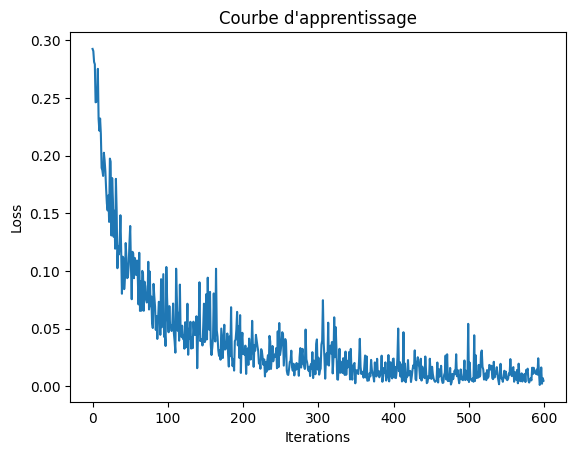

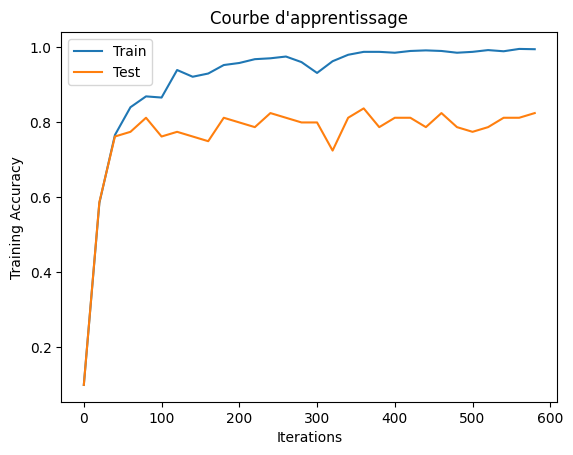

Précision finale Train : 0.9953125
Précision finale Test : 0.825
Meilleur Précision finale Train : 0.99609375
Meilleur Précision finale Test : 0.8375
Training completed in 55.19 seconds
Training with batch size 16, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.13701871037483215
Acc Train: 0.20546875
Acc Test: 0.25
Epoch: 1
Loss: 0.12766580283641815
Acc Train: 0.3515625
Acc Test: 0.4375
Epoch: 2
Loss: 0.11712638288736343
Acc Train: 0.61796875
Acc Test: 0.6625
Epoch: 3
Loss: 0.09756166487932205
Acc Train: 0.66484375
Acc Test: 0.7125
Epoch: 4
Loss: 0.08219573646783829
Acc Train: 0.7125
Acc Test: 0.775
Epoch: 5
Loss: 0.09124810993671417
Acc Train: 0.7203125
Acc Test: 0.75
Epoch: 6
Loss: 0.06564494222402573
Acc Train: 0.7546875
Acc Test: 0.725
Epoch: 7
Loss: 0.0845821276307106
Acc Train: 0.7515625
Acc Test: 0.7625
Epoch: 8
Loss: 0.07188290357589722
Acc Train: 0.7859375
Acc Test: 0.775
Epoch: 9
Loss: 0.056997377425432205
Acc Train: 0.7484375
Acc Test: 0.725
Epoch: 10
Loss: 0.048960473

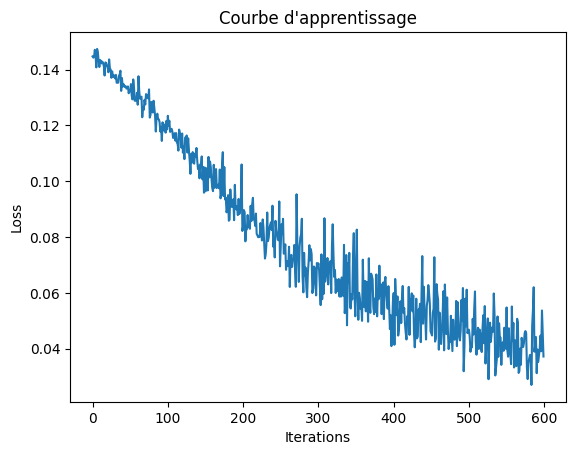

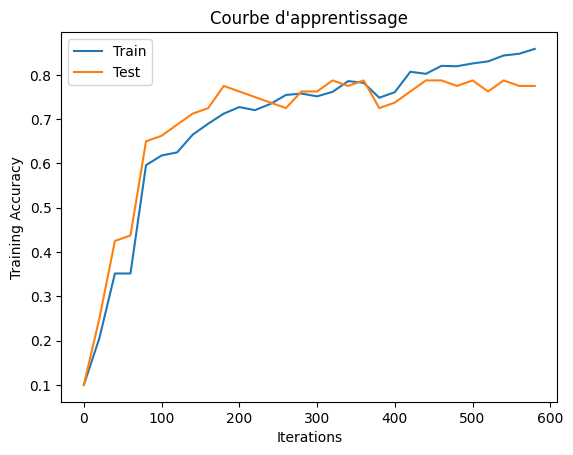

Précision finale Train : 0.85859375
Précision finale Test : 0.775
Meilleur Précision finale Train : 0.85859375
Meilleur Précision finale Test : 0.7875
Training completed in 54.59 seconds
Training with batch size 16, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.058271024376153946
Acc Train: 0.45703125
Acc Test: 0.525
Epoch: 1
Loss: 0.04098978266119957
Acc Train: 0.8
Acc Test: 0.7375
Epoch: 2
Loss: 0.026896009221673012
Acc Train: 0.88984375
Acc Test: 0.775
Epoch: 3
Loss: 0.016331475228071213
Acc Train: 0.93671875
Acc Test: 0.7625
Epoch: 4
Loss: 0.017011679708957672
Acc Train: 0.97578125
Acc Test: 0.8375
Epoch: 5
Loss: 0.016439300030469894
Acc Train: 0.965625
Acc Test: 0.8
Epoch: 6
Loss: 0.008617782033979893
Acc Train: 0.97734375
Acc Test: 0.8
Epoch: 7
Loss: 0.003994963131844997
Acc Train: 0.9796875
Acc Test: 0.775
Epoch: 8
Loss: 0.006107763387262821
Acc Train: 0.9703125
Acc Test: 0.8
Epoch: 9
Loss: 0.005078532733023167
Acc Train: 0.978125
Acc Test: 0.825
Epoch: 10
Loss: 0.015177

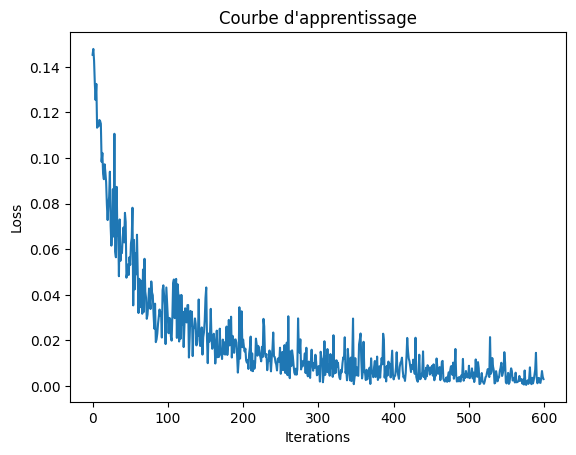

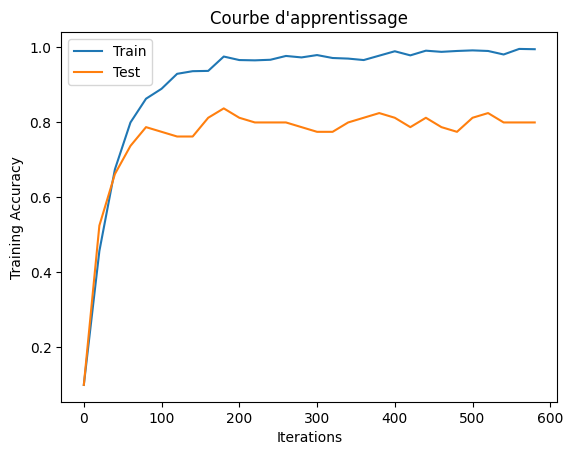

Précision finale Train : 0.9953125
Précision finale Test : 0.8
Meilleur Précision finale Train : 0.99609375
Meilleur Précision finale Test : 0.8375
Training completed in 55.48 seconds
Training with batch size 32, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.06907745450735092
Acc Train: 0.19375
Acc Test: 0.2
Epoch: 1
Loss: 0.06117580831050873
Acc Train: 0.48515625
Acc Test: 0.5125
Epoch: 2
Loss: 0.05661462992429733
Acc Train: 0.5359375
Acc Test: 0.5125
Epoch: 3
Loss: 0.046894606202840805
Acc Train: 0.6375
Acc Test: 0.65
Epoch: 4
Loss: 0.04789402708411217
Acc Train: 0.66328125
Acc Test: 0.6875
Epoch: 5
Loss: 0.03836418315768242
Acc Train: 0.6640625
Acc Test: 0.675
Epoch: 6
Loss: 0.03385666385293007
Acc Train: 0.69296875
Acc Test: 0.6875
Epoch: 7
Loss: 0.03305986523628235
Acc Train: 0.7234375
Acc Test: 0.7125
Epoch: 8
Loss: 0.026382185518741608
Acc Train: 0.7265625
Acc Test: 0.7125
Epoch: 9
Loss: 0.029466673731803894
Acc Train: 0.73046875
Acc Test: 0.7625
Epoch: 10
Loss: 0.0298745

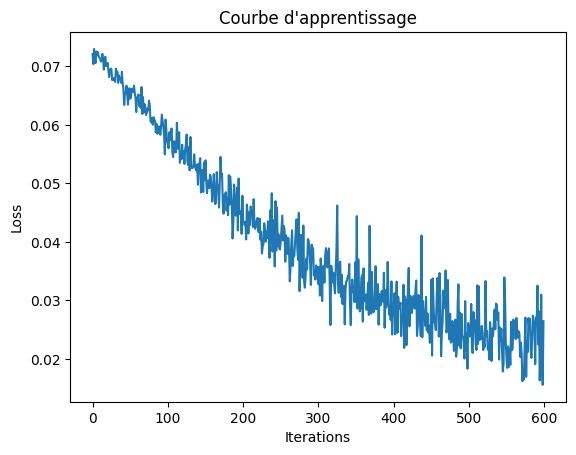

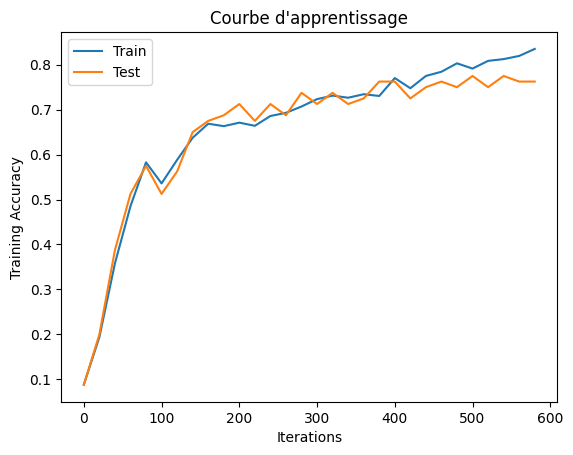

Précision finale Train : 0.83515625
Précision finale Test : 0.7625
Meilleur Précision finale Train : 0.83515625
Meilleur Précision finale Test : 0.775
Training completed in 54.62 seconds
Training with batch size 32, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.035913970321416855
Acc Train: 0.471875
Acc Test: 0.4625
Epoch: 1
Loss: 0.028633521869778633
Acc Train: 0.815625
Acc Test: 0.7375
Epoch: 2
Loss: 0.013762487098574638
Acc Train: 0.9015625
Acc Test: 0.775
Epoch: 3
Loss: 0.006336471997201443
Acc Train: 0.90703125
Acc Test: 0.7625
Epoch: 4
Loss: 0.01006955374032259
Acc Train: 0.9515625
Acc Test: 0.775
Epoch: 5
Loss: 0.007810146082192659
Acc Train: 0.9640625
Acc Test: 0.825
Epoch: 6
Loss: 0.004942075815051794
Acc Train: 0.9328125
Acc Test: 0.8
Epoch: 7
Loss: 0.004393482115119696
Acc Train: 0.97265625
Acc Test: 0.8
Epoch: 8
Loss: 0.002906368812546134
Acc Train: 0.98046875
Acc Test: 0.825
Epoch: 9
Loss: 0.001314831548370421
Acc Train: 0.9765625
Acc Test: 0.8
Epoch: 10
Loss: 0.00

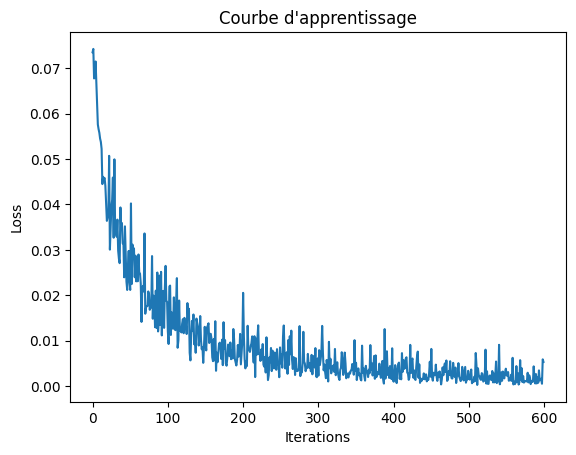

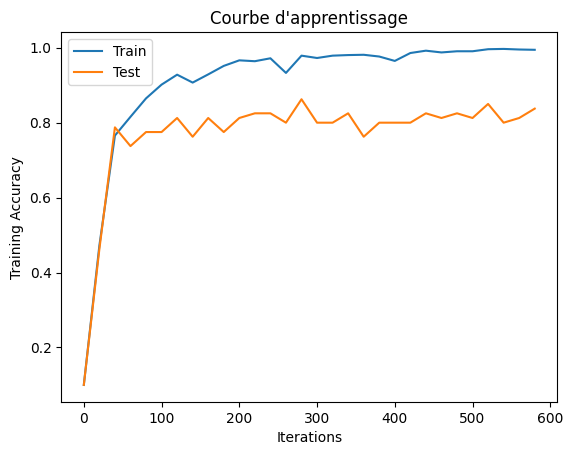

Précision finale Train : 0.99453125
Précision finale Test : 0.8375
Meilleur Précision finale Train : 0.996875
Meilleur Précision finale Test : 0.8625
Training completed in 55.08 seconds
Training with batch size 64, learning rate 0.0001, optimizer sgd
Epoch: 0
Loss: 0.034134894609451294
Acc Train: 0.10703125
Acc Test: 0.1
Epoch: 1
Loss: 0.030931396409869194
Acc Train: 0.38828125
Acc Test: 0.425
Epoch: 2
Loss: 0.027133338153362274
Acc Train: 0.50859375
Acc Test: 0.4875
Epoch: 3
Loss: 0.025977734476327896
Acc Train: 0.6125
Acc Test: 0.6125
Epoch: 4
Loss: 0.022236939519643784
Acc Train: 0.678125
Acc Test: 0.6625
Epoch: 5
Loss: 0.017536785453557968
Acc Train: 0.67578125
Acc Test: 0.65
Epoch: 6
Loss: 0.018307501450181007
Acc Train: 0.69375
Acc Test: 0.675
Epoch: 7
Loss: 0.01847700960934162
Acc Train: 0.7359375
Acc Test: 0.725
Epoch: 8
Loss: 0.016053929924964905
Acc Train: 0.77265625
Acc Test: 0.75
Epoch: 9
Loss: 0.011624814942479134
Acc Train: 0.79921875
Acc Test: 0.7375
Epoch: 10
Loss: 0.01

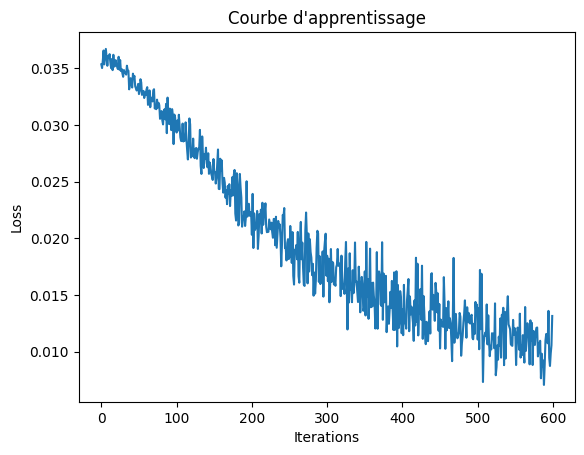

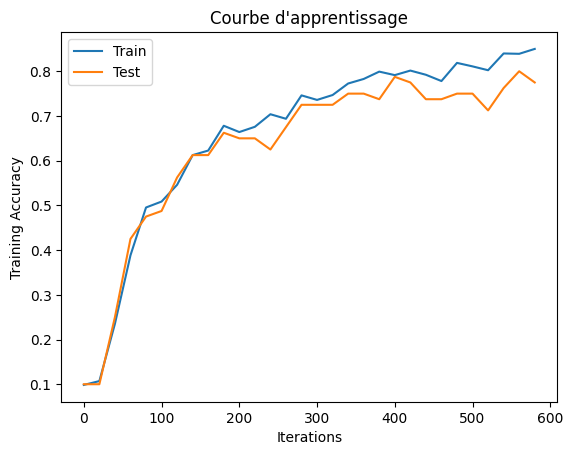

Précision finale Train : 0.85
Précision finale Test : 0.775
Meilleur Précision finale Train : 0.85
Meilleur Précision finale Test : 0.8
Training completed in 55.93 seconds
Training with batch size 64, learning rate 0.0001, optimizer adam
Epoch: 0
Loss: 0.014319317415356636
Acc Train: 0.5578125
Acc Test: 0.6
Epoch: 1
Loss: 0.008093489333987236
Acc Train: 0.8578125
Acc Test: 0.7375
Epoch: 2
Loss: 0.007084832992404699
Acc Train: 0.8984375
Acc Test: 0.8125
Epoch: 3
Loss: 0.0032427844125777483
Acc Train: 0.8953125
Acc Test: 0.7875
Epoch: 4
Loss: 0.0033855107612907887
Acc Train: 0.93671875
Acc Test: 0.7875
Epoch: 5
Loss: 0.0018944689072668552
Acc Train: 0.975
Acc Test: 0.8375
Epoch: 6
Loss: 0.004340475890785456
Acc Train: 0.9734375
Acc Test: 0.8125
Epoch: 7
Loss: 0.003516889875754714
Acc Train: 0.97421875
Acc Test: 0.8125
Epoch: 8
Loss: 0.0025487311650067568
Acc Train: 0.98046875
Acc Test: 0.8375
Epoch: 9
Loss: 0.0009602943900972605
Acc Train: 0.98359375
Acc Test: 0.7875
Epoch: 10
Loss: 0.00

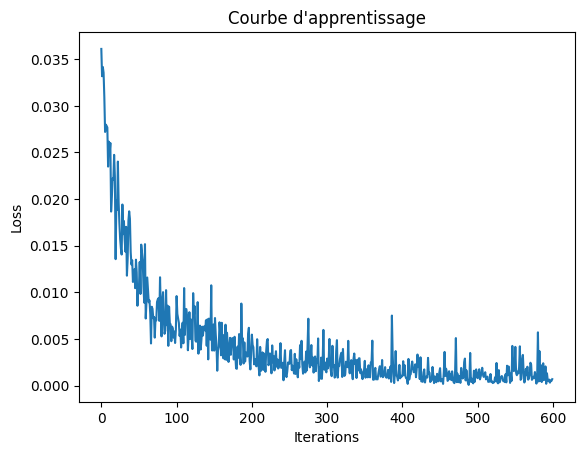

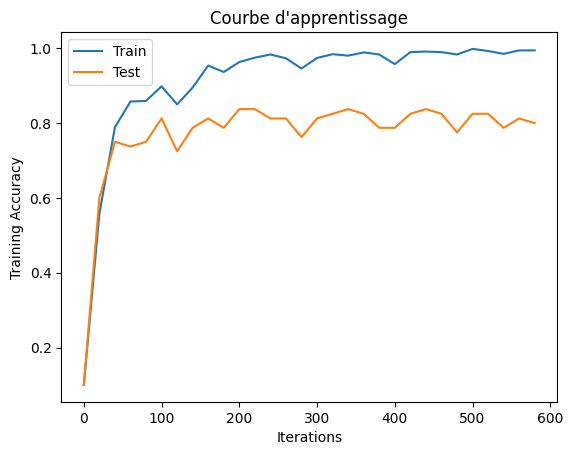

Précision finale Train : 0.99453125
Précision finale Test : 0.8
Meilleur Précision finale Train : 0.9984375
Meilleur Précision finale Test : 0.8375
Training completed in 56.74 seconds
Total computation time for all model trainings: 983.65 seconds
{'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.84453125, 'best_test_acc': 0.7875, 'training_duration': 54.51661539077759}
{'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'adam', 'best_train_acc': 0.99609375, 'best_test_acc': 0.8375, 'training_duration': 55.19302034378052}
{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.85859375, 'best_test_acc': 0.7875, 'training_duration': 54.592915296554565}
{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'adam', 'best_train_acc': 0.99609375, 'best_test_acc': 0.8375, 'training_duration': 55.48188281059265}
{'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'best_train_acc': 0.83515625, 'best_test_acc': 0.775

In [55]:
# Iterate over each combination of parameters
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            print(f"Training with batch size {batch_size}, learning rate {learning_rate}, optimizer {optimizer}")
            training_start_time = time.time()
            model = ComplexCNN()
            # Run training and get the best accuracies
            best_train_acc, best_test_acc = train(model, train_loader_all, test_loader, batch_size=batch_size, 
                                                  weight_decay=0.0, optimizer=optimizer, 
                                                  learning_rate=learning_rate, num_epochs=num_epochs)

            # Calculate and print the time taken for the current training session
            training_end_time = time.time()
            training_duration = training_end_time - training_start_time
            print(f"Training completed in {training_duration:.2f} seconds")

            # Store the results
            results.append({
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'optimizer': optimizer,
                'best_train_acc': best_train_acc,
                'best_test_acc': best_test_acc,
                'training_duration': training_duration
            })

# Calculate and print the total time taken for all training sessions
end_time = time.time()
print(f"Total computation time for all model trainings: {end_time - start_time:.2f} seconds")

# Optionally print all results
for result in results:
    print(result)

Epoch: 0
Loss: 0.0302281454205513
Acc Train: 0.1
Acc Test: 0.1
Epoch: 1
Loss: 0.025889702141284943
Acc Train: 0.1
Acc Test: 0.1
Epoch: 2
Loss: 0.02053268626332283
Acc Train: 0.43125
Acc Test: 0.3375
Epoch: 3
Loss: 0.017911478877067566
Acc Train: 0.43125
Acc Test: 0.3375
Epoch: 4
Loss: 0.013024425134062767
Acc Train: 0.5875
Acc Test: 0.525
Epoch: 5
Loss: 0.0132827740162611
Acc Train: 0.5875
Acc Test: 0.525
Epoch: 6
Loss: 0.011849521659314632
Acc Train: 0.80625
Acc Test: 0.6
Epoch: 7
Loss: 0.007921315729618073
Acc Train: 0.80625
Acc Test: 0.6
Epoch: 8
Loss: 0.009383542463183403
Acc Train: 0.871875
Acc Test: 0.7125
Epoch: 9
Loss: 0.005224679131060839
Acc Train: 0.871875
Acc Test: 0.7125
Epoch: 10
Loss: 0.006287060212343931
Acc Train: 0.8625
Acc Test: 0.6625
Epoch: 11
Loss: 0.004653024487197399
Acc Train: 0.8625
Acc Test: 0.6625
Epoch: 12
Loss: 0.009339156560599804
Acc Train: 0.921875
Acc Test: 0.7
Epoch: 13
Loss: 0.007881524041295052
Acc Train: 0.921875
Acc Test: 0.7
Epoch: 14
Loss: 0.004

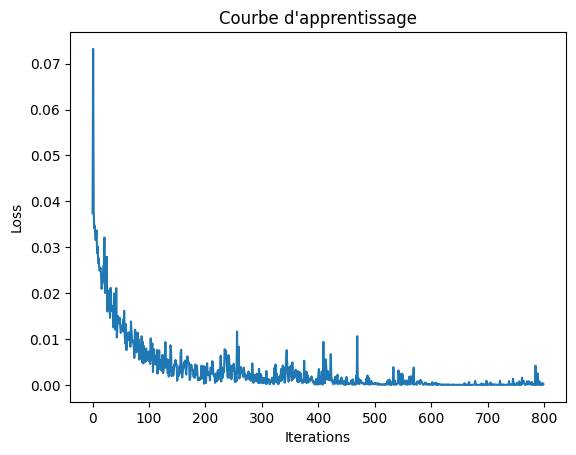

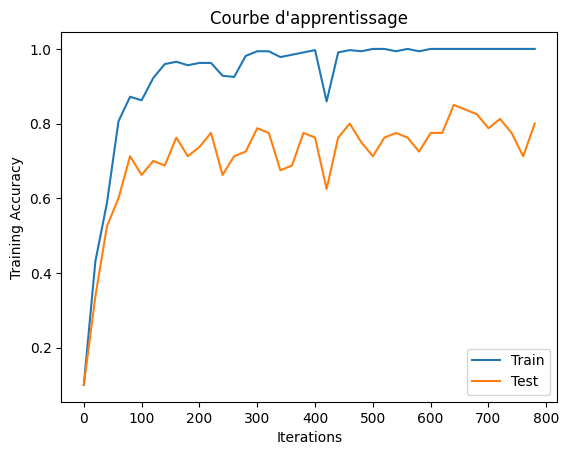

Précision finale Train : 1.0
Précision finale Test : 0.8


In [71]:
train(model, batch_size=64, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=80)

Epoch: 0
Loss: 0.028162553906440735
Acc Train: 0.115625
Acc Test: 0.1125
Epoch: 1
Loss: 0.01921592652797699
Acc Train: 0.115625
Acc Test: 0.1125
Epoch: 2
Loss: 0.013518272899091244
Acc Train: 0.671875
Acc Test: 0.6
Epoch: 3
Loss: 0.012997174635529518
Acc Train: 0.671875
Acc Test: 0.6
Epoch: 4
Loss: 0.01464731153100729
Acc Train: 0.790625
Acc Test: 0.6625
Epoch: 5
Loss: 0.007996361702680588
Acc Train: 0.790625
Acc Test: 0.6625
Epoch: 6
Loss: 0.008853697218000889
Acc Train: 0.85
Acc Test: 0.725
Epoch: 7
Loss: 0.012093236669898033
Acc Train: 0.85
Acc Test: 0.725
Epoch: 8
Loss: 0.006861015688627958
Acc Train: 0.8875
Acc Test: 0.75
Epoch: 9
Loss: 0.006054663099348545
Acc Train: 0.8875
Acc Test: 0.75
Epoch: 10
Loss: 0.005650380626320839
Acc Train: 0.909375
Acc Test: 0.75
Epoch: 11
Loss: 0.0048696426674723625
Acc Train: 0.909375
Acc Test: 0.75
Epoch: 12
Loss: 0.0035385468509048223
Acc Train: 0.946875
Acc Test: 0.75
Epoch: 13
Loss: 0.00614854646846652
Acc Train: 0.946875
Acc Test: 0.75
Epoch: 

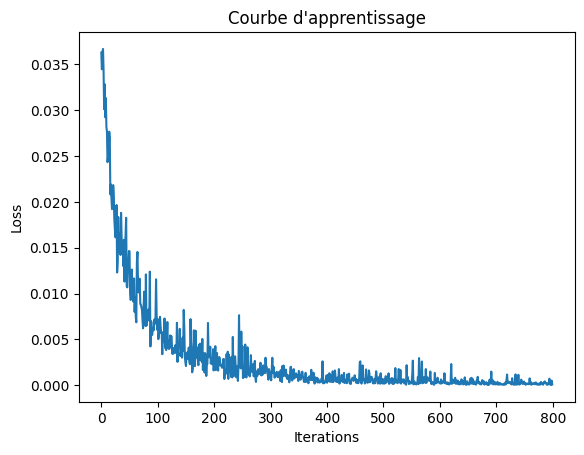

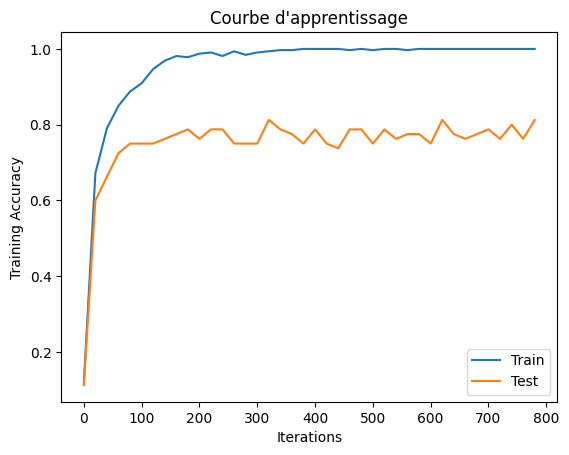

Précision finale Train : 1.0
Précision finale Test : 0.8125


In [78]:
train(model, batch_size=64, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=80)

Essayer d'améliorer le MLP, jouer avec son architecture : changer la fonction d'activation, modifier le nombre de couches, ajouter une normalisation des activations...

Même chose avec le CNN.

Vous pouvez améliorer les hyperparamètres d'apprentissage de la fonction train.

Essayer les deux optimiseurs proposés. L'un est-il meilleur que l'autre pour la tâche donnée ? Pensez-vous avoir une bonne valeur de taux d'apprentissage pour SGD (et pour ADAM) ?

Une fois que vous avez votre meilleur modèle, faites une matrice de confusion qui montre les pourcentages de confusion entre les 10 classes sur le jeu de test.

Pour aller plus loin : quelles augmentations pourraient êter pertinentes pour augmenter les spectrogrammes ?

In [ ]:
train(model, batch_size=64, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, num_epochs=80)